## Safe Driver Prediction -- Kaggle Competition  ####

#### Overview (from competition sponsors):  #### 
Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting is even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they are looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

#### Data ####     
Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target column signifies whether or not a claim was filed for that policy holder.

The data was fully anonymized by Porto Seguro (including the exact meaning of each column header).  As a result, there is little opportunity to bring in business/industry knowledge to the challenge.  The data also appears to have alredy been highly processed/engineered. 

#### Evaluation  
Predictions are scored using the Normalized Gini Coefficient, a variation on the commonly used AUC (Area Under the Curve) measure.

#### Core files  
* train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
* test.csv contains the test data.
* sample_submission.csv is submission file showing the correct format.

Files derived from the above are saved throughout. 

**My Approach**

Following data exploration, I conducted mutliple rounds of data pre-processing, iteratively along with preliminary predictive modeling.  

The key data transformations were to fill missing values with either interpolated values (using predictive models) or mean values.  I also added features based on unsupervised clustering. 

The data was a mix of binary, categorical and continuous data.  The Light GBM model used does not require binarization for categorical features; however, some of the other models do.  As a result, I used binarized datasets for models that required or performed better with them.  However, the Light GBM model performed better with un-binarized data. 

After fully tuning a Light GBM model, I tried to surpass the stand-alone model's Gini scores by various stacking techniques -- including running a meta model on the predictive outputs of several base models (e.g., Naive Bayes, KNN), averaging predictive scores across base models and incorporating the base models' predictions as new features into a meta Light GBM model.  

In the end, the stand-alone Light GBM model performed as well as the stacked models.  

In [1]:
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 15

In [484]:
# Read in the core datasets 
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_sample_submission=pd.read_csv('sample_submission.csv')

** Exploratory Data Analysis **

In [49]:
df_train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [50]:
df_train.shape

(595212, 59)

In [51]:
df_test.columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

In [52]:
df_test.shape

(892816, 58)

In [53]:
df_sample_submission.columns

Index(['id', 'target'], dtype='object')

In [54]:
df_sample_submission.head()

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


In [55]:
# Identify differences in columns between the train and test data 
df_train.columns.difference(df_test.columns)

Index(['target'], dtype='object')

The train and test datasets have same columns as test, except there is a target variable in train. We will use df_train for the data exploration.  Let's look at the target variable first. 

In [56]:
df_train.target.value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [57]:
print("The percentage of customers with a claim is: ", (df_train.target ==1).sum() / len(df_train.target))

The percentage of customers with a claim is:  0.0364475178592


Now we look at the other columns -- ie, potential features 

In [58]:
df_train.head(2)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0


In [59]:
df_train.isnull().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


In [60]:
# No NaNs, but data description said NaNs were replaced by -1; here are those percentages; ps_reg_03 has about 1 in 5 missing 
percentages=(df_train== -1).sum() / len(df_train)
percentages=round(percentages, 2)
print("Percentage of column values with Nan's (-1s) : ", percentages)

Percentage of column values with Nan's (-1s) :  id                0.00
target            0.00
ps_ind_01         0.00
ps_ind_02_cat     0.00
ps_ind_03         0.00
ps_ind_04_cat     0.00
ps_ind_05_cat     0.01
ps_ind_06_bin     0.00
ps_ind_07_bin     0.00
ps_ind_08_bin     0.00
ps_ind_09_bin     0.00
ps_ind_10_bin     0.00
ps_ind_11_bin     0.00
ps_ind_12_bin     0.00
ps_ind_13_bin     0.00
ps_ind_14         0.00
ps_ind_15         0.00
ps_ind_16_bin     0.00
ps_ind_17_bin     0.00
ps_ind_18_bin     0.00
ps_reg_01         0.00
ps_reg_02         0.00
ps_reg_03         0.18
ps_car_01_cat     0.00
ps_car_02_cat     0.00
ps_car_03_cat     0.69
ps_car_04_cat     0.00
ps_car_05_cat     0.45
ps_car_06_cat     0.00
ps_car_07_cat     0.02
ps_car_08_cat     0.00
ps_car_09_cat     0.00
ps_car_10_cat     0.00
ps_car_11_cat     0.00
ps_car_11         0.00
ps_car_12         0.00
ps_car_13         0.00
ps_car_14         0.07
ps_car_15         0.00
ps_calc_01        0.00
ps_calc_02        0.00
ps_calc_0

In [62]:
x=percentages.loc[percentages>0.02]
x

ps_reg_03        0.18
ps_car_03_cat    0.69
ps_car_05_cat    0.45
ps_car_14        0.07
dtype: float64

In [63]:
high_nan_cols=x.index.values
high_nan_cols

array(['ps_reg_03', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_14'], dtype=object)

In [64]:
del x, percentages; gc.collect()

21566

Distributions of the data 

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [66]:
df_train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


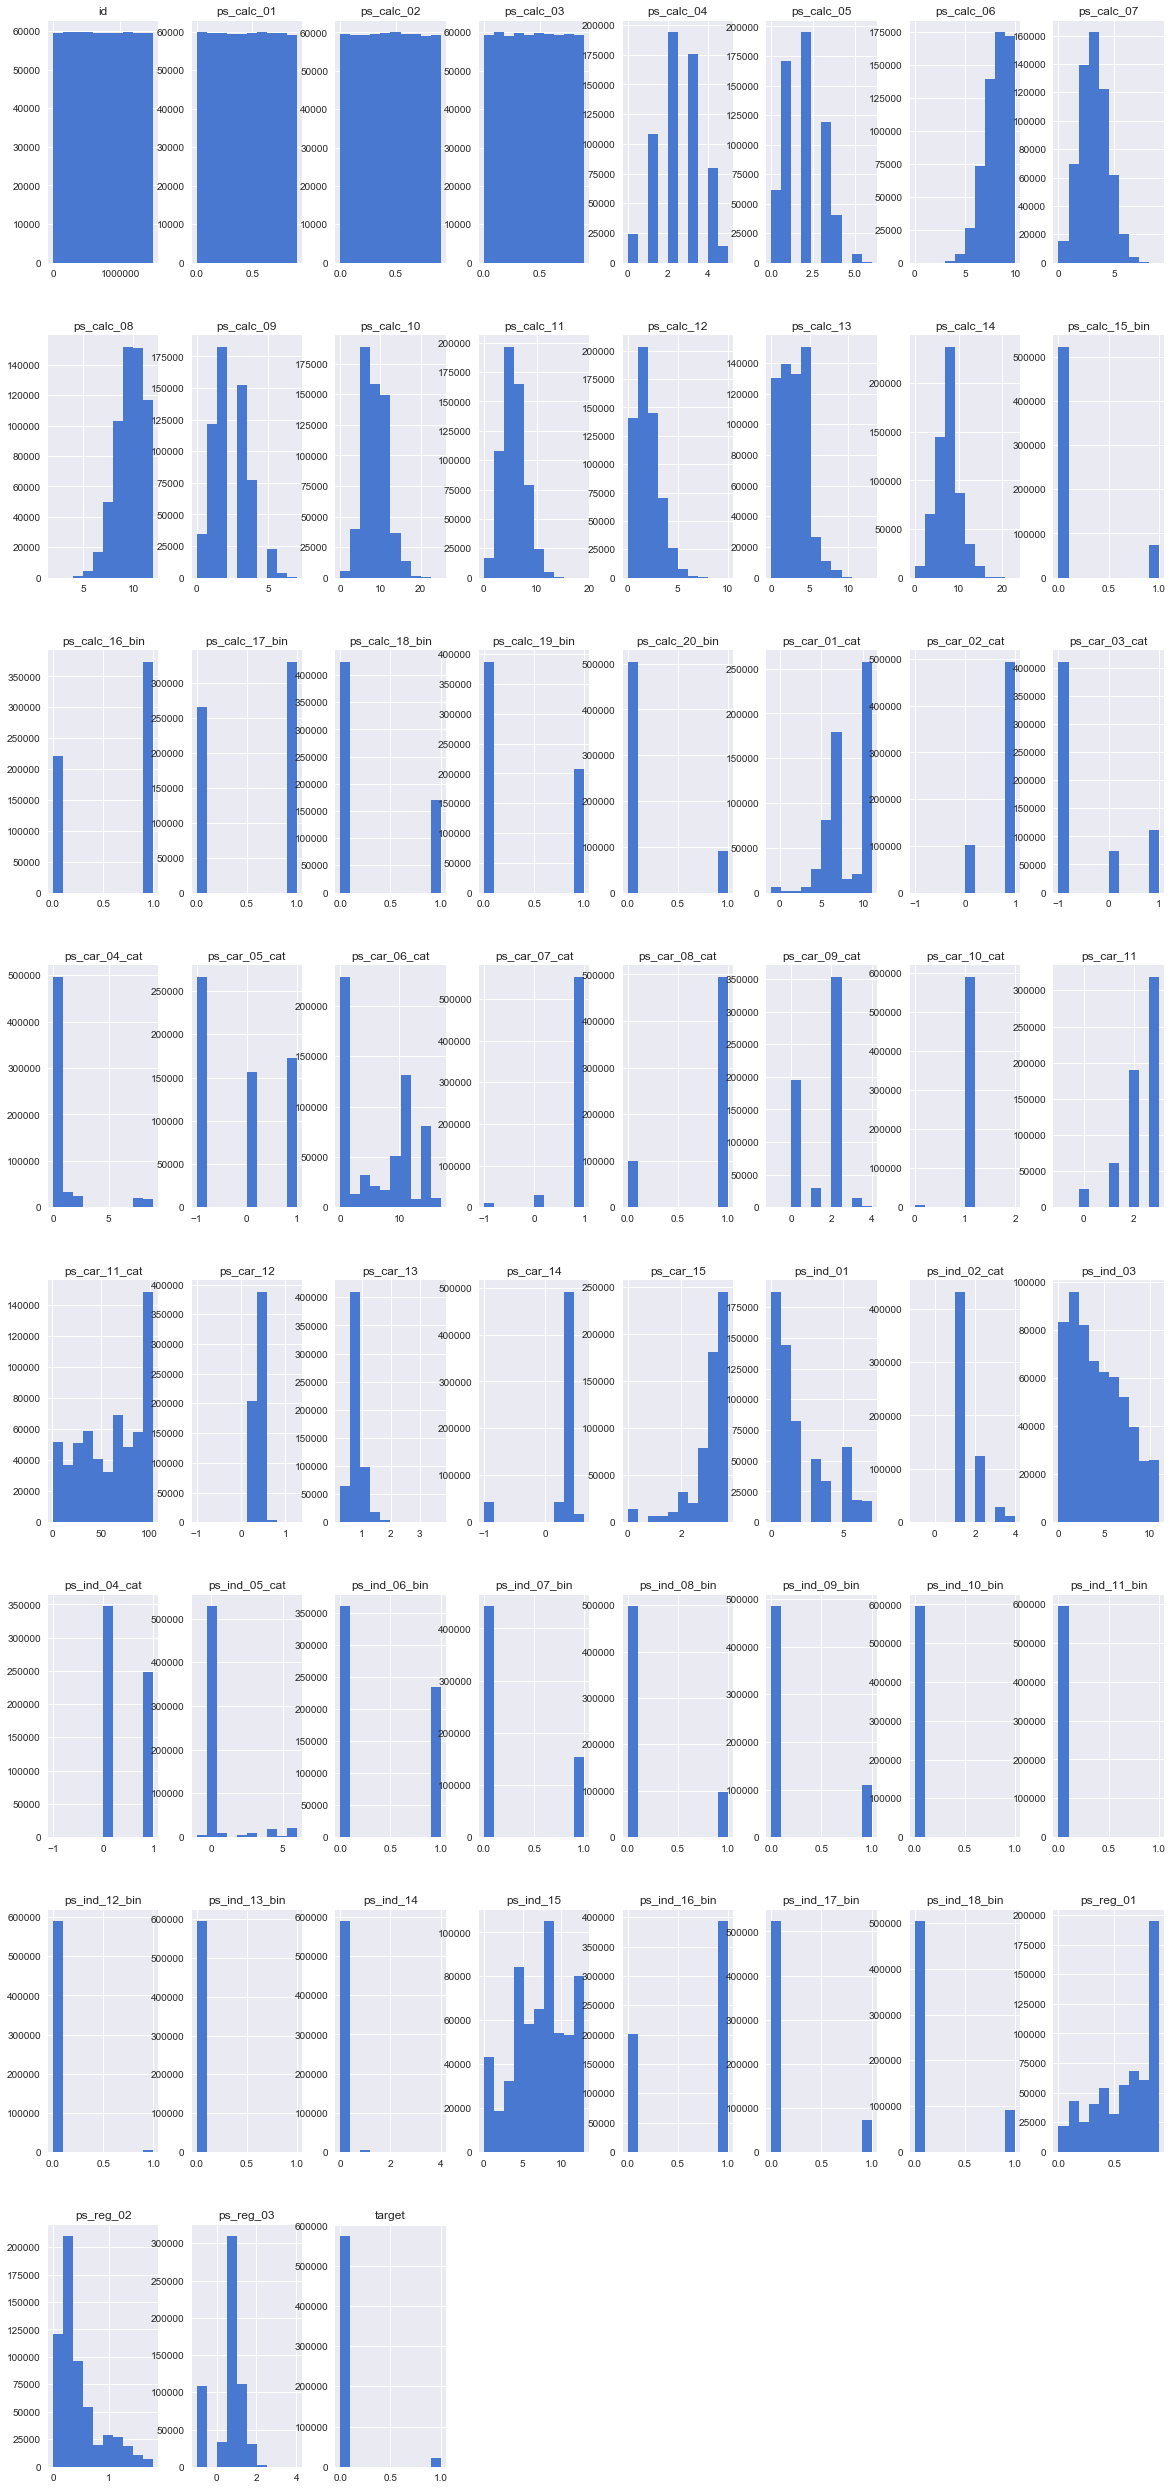

In [67]:
df_train.hist(figsize=(20,45))
plt.show()

In [68]:
# Determine unique values by column 
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(df_train)

id | 595212 | int64
target | 2 | int64
ps_ind_01 | 8 | int64
ps_ind_02_cat | 5 | int64
ps_ind_03 | 12 | int64
ps_ind_04_cat | 3 | int64
ps_ind_05_cat | 8 | int64
ps_ind_06_bin | 2 | int64
ps_ind_07_bin | 2 | int64
ps_ind_08_bin | 2 | int64
ps_ind_09_bin | 2 | int64
ps_ind_10_bin | 2 | int64
ps_ind_11_bin | 2 | int64
ps_ind_12_bin | 2 | int64
ps_ind_13_bin | 2 | int64
ps_ind_14 | 5 | int64
ps_ind_15 | 14 | int64
ps_ind_16_bin | 2 | int64
ps_ind_17_bin | 2 | int64
ps_ind_18_bin | 2 | int64
ps_reg_01 | 10 | float64
ps_reg_02 | 19 | float64
ps_reg_03 | 5013 | float64
ps_car_01_cat | 13 | int64
ps_car_02_cat | 3 | int64
ps_car_03_cat | 3 | int64
ps_car_04_cat | 10 | int64
ps_car_05_cat | 3 | int64
ps_car_06_cat | 18 | int64
ps_car_07_cat | 3 | int64
ps_car_08_cat | 2 | int64
ps_car_09_cat | 6 | int64
ps_car_10_cat | 3 | int64
ps_car_11_cat | 104 | int64
ps_car_11 | 5 | int64
ps_car_12 | 184 | float64
ps_car_13 | 70482 | float64
ps_car_14 | 850 | float64
ps_car_15 | 15 | float64
ps_calc_01 |

We have 595,212 unique customers. The rest of the variables, with few exceptions, appear to be categorical or binned or continuous but with a relatively small number of values. For example, there are just three features with more than 26 unique values.  

Ignoring the prefix of each feature ("ps," which likely stands for Portp Seguro, the insurer) and the id and target variables, 
there are four categories at the next level: "ind", which may refer to individual customer characteristics; "reg," which may have to do with the registration of the car; "car," which likely refers to car characteristics; and "calc," which likely refers to calculated values. 

Correlations 

In [69]:
# Remove id from the columns 
df1 = df_train.iloc[:,1:]

In [70]:
# Calculate correlation between each pair of variable
corr_matrix=df1.corr()
corr_matrix

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
target,1.000000,0.018570,0.004534,0.008360,0.009360,0.029165,-0.034017,0.034218,0.013147,-0.008237,...,0.000371,-0.001133,-0.000446,0.001362,-0.000490,0.000624,-0.000170,0.000552,-0.001744,-0.001072
ps_ind_01,0.018570,1.000000,-0.001793,0.223408,0.066645,0.014823,-0.277458,0.005700,0.188583,0.162800,...,-0.001263,0.001521,0.000199,-0.000891,-0.000397,-0.000012,-0.000868,-0.001504,-0.000162,-0.001464
ps_ind_02_cat,0.004534,-0.001793,1.000000,-0.061189,0.147110,-0.014860,-0.125653,0.016398,0.030945,0.110076,...,0.000038,-0.000884,-0.000893,-0.000519,-0.000109,0.000920,0.000547,0.000824,0.000367,-0.002070
ps_ind_03,0.008360,0.223408,-0.061189,1.000000,-0.095856,0.053250,-0.045158,-0.060368,0.014037,0.111306,...,-0.002716,-0.002352,0.000133,0.000205,0.000134,-0.000744,0.000158,-0.000218,-0.000882,-0.003709
ps_ind_04_cat,0.009360,0.066645,0.147110,-0.095856,1.000000,0.013053,-0.297737,0.304949,0.044978,-0.011442,...,-0.002001,-0.000814,0.000283,0.001565,0.002735,0.002295,0.000773,0.000916,-0.001966,0.001244
ps_ind_05_cat,0.029165,0.014823,-0.014860,0.053250,0.013053,1.000000,0.009619,-0.010382,0.004881,-0.005069,...,-0.001525,0.000975,0.001549,0.002171,0.001548,-0.000368,0.000153,0.000032,0.000276,0.000279
ps_ind_06_bin,-0.034017,-0.277458,-0.125653,-0.045158,-0.297737,0.009619,1.000000,-0.474009,-0.356838,-0.384345,...,0.000822,0.001347,-0.001301,0.000304,0.002088,-0.000381,-0.000001,-0.000759,0.002791,0.000203
ps_ind_07_bin,0.034218,0.005700,0.016398,-0.060368,0.304949,-0.010382,-0.474009,1.000000,-0.260438,-0.280513,...,-0.000448,-0.001044,0.000541,0.001666,0.000575,0.001220,-0.000517,0.000181,-0.001361,-0.000961
ps_ind_08_bin,0.013147,0.188583,0.030945,0.014037,0.044978,0.004881,-0.356838,-0.260438,1.000000,-0.211173,...,-0.000632,-0.001241,-0.000432,-0.001959,-0.002782,-0.002048,-0.000579,-0.000068,-0.000919,0.000995
ps_ind_09_bin,-0.008237,0.162800,0.110076,0.111306,-0.011442,-0.005069,-0.384345,-0.280513,-0.211173,1.000000,...,0.000072,0.000664,0.001439,-0.000389,-0.000621,0.001059,0.001135,0.000815,-0.001103,-0.000123


In [71]:
# Focusing on correlations with target value 
corr_matrix.target.sort_values(ascending=False)

target            1.000000
ps_car_13         0.053899
ps_car_12         0.038790
ps_ind_17_bin     0.037053
ps_reg_02         0.034800
ps_ind_07_bin     0.034218
ps_car_04_cat     0.032900
ps_car_03_cat     0.032401
ps_reg_03         0.030888
ps_ind_05_cat     0.029165
ps_car_15         0.027667
ps_reg_01         0.022888
ps_car_05_cat     0.020754
ps_ind_01         0.018570
ps_car_01_cat     0.016256
ps_ind_08_bin     0.013147
ps_car_06_cat     0.011537
ps_ind_04_cat     0.009360
ps_ind_03         0.008360
ps_ind_12_bin     0.007810
ps_ind_14         0.007443
ps_car_11_cat     0.006129
ps_car_09_cat     0.005322
ps_ind_18_bin     0.004555
ps_ind_02_cat     0.004534
ps_ind_13_bin     0.002460
ps_ind_11_bin     0.002028
ps_calc_03        0.001907
ps_ind_10_bin     0.001815
ps_calc_01        0.001782
ps_calc_14        0.001362
ps_calc_02        0.001360
ps_calc_10        0.001061
ps_car_10_cat     0.001038
ps_calc_05        0.000771
ps_calc_09        0.000719
ps_calc_16_bin    0.000624
p

Overall, weak correlations between each feature and target variable.  Most correlated feature is ps_car_13 with a score of 0.053899. This might be for something like mileage driven.   

In [72]:
min(corr_matrix.min())

-0.59426543274409926

In [73]:
max(corr_matrix.max())

1.0

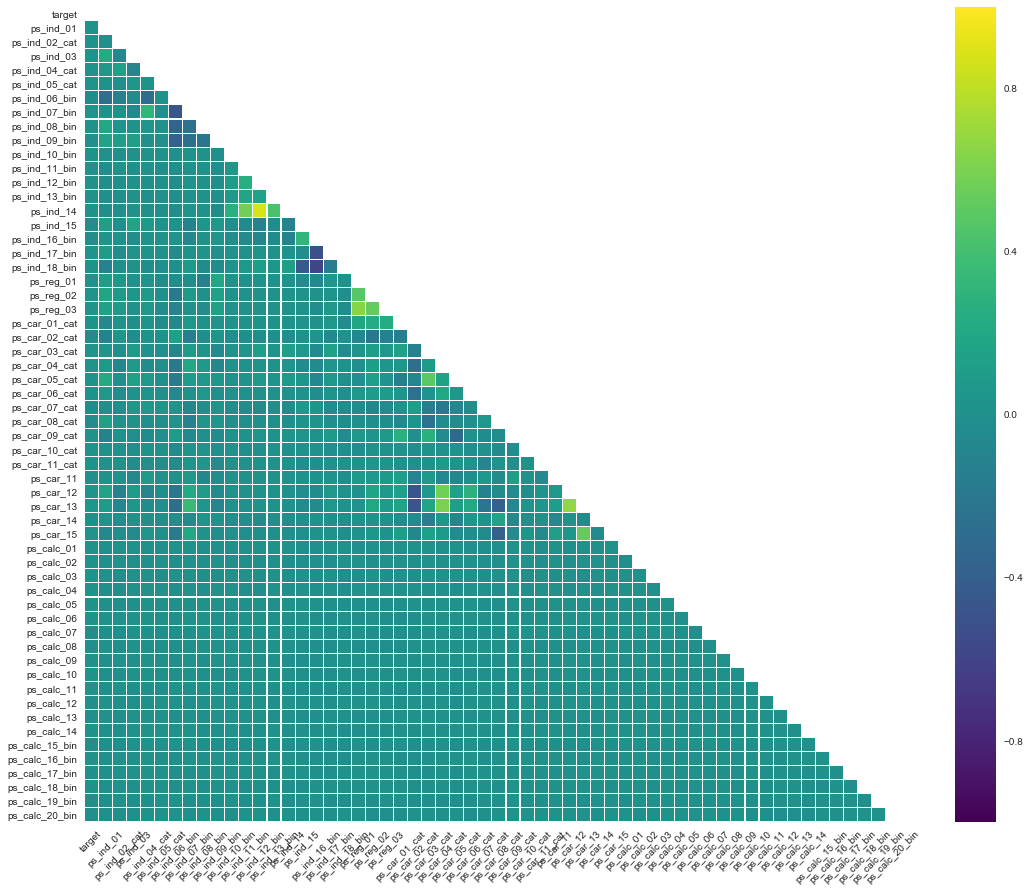

In [81]:
# plot it
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix, mask=mask, square=True, cmap='viridis', linewidths=0.1, linecolor='white')
    plt.xticks(rotation=45) 

In [75]:
# Droping the "calc" columns and rows from the correlation matrix (the bottom part of graph above, which basically show
# 0.0 correlations) in order to focus on the correlated data 
corr_matrix_sub=corr_matrix.loc['target' : 'ps_car_15', 'target' : 'ps_car_15']

In [76]:
corr_matrix_sub

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
target,1.000000,0.018570,0.004534,0.008360,0.009360,0.029165,-0.034017,0.034218,0.013147,-0.008237,...,-0.036395,-0.020342,0.005322,0.001038,0.006129,-0.001213,0.038790,0.053899,-0.004474,0.027667
ps_ind_01,0.018570,1.000000,-0.001793,0.223408,0.066645,0.014823,-0.277458,0.005700,0.188583,0.162800,...,-0.000639,0.138112,-0.102582,0.010794,0.008188,0.008252,0.161842,0.099752,0.034480,-0.056722
ps_ind_02_cat,0.004534,-0.001793,1.000000,-0.061189,0.147110,-0.014860,-0.125653,0.016398,0.030945,0.110076,...,-0.011781,0.001526,0.009435,0.011401,0.014955,0.019949,-0.110247,-0.080408,-0.012272,-0.008391
ps_ind_03,0.008360,0.223408,-0.061189,1.000000,-0.095856,0.053250,-0.045158,-0.060368,0.014037,0.111306,...,0.056337,0.003607,-0.013205,-0.008561,-0.025966,-0.059358,0.088992,0.048308,0.000539,-0.048096
ps_ind_04_cat,0.009360,0.066645,0.147110,-0.095856,1.000000,0.013053,-0.297737,0.304949,0.044978,-0.011442,...,0.064655,-0.008148,-0.041983,0.023010,-0.000615,0.073486,-0.095160,-0.032233,-0.005596,0.040480
ps_ind_05_cat,0.029165,0.014823,-0.014860,0.053250,0.013053,1.000000,0.009619,-0.010382,0.004881,-0.005069,...,0.053777,-0.002084,-0.008334,0.002168,-0.002250,0.001076,-0.016302,-0.015259,-0.001427,-0.006629
ps_ind_06_bin,-0.034017,-0.277458,-0.125653,-0.045158,-0.297737,0.009619,1.000000,-0.474009,-0.356838,-0.384345,...,0.038994,0.038313,0.099184,-0.041057,-0.031296,0.019618,-0.218117,-0.272210,-0.005695,-0.165981
ps_ind_07_bin,0.034218,0.005700,0.016398,-0.060368,0.304949,-0.010382,-0.474009,1.000000,-0.260438,-0.280513,...,-0.064708,-0.123825,-0.059229,0.030556,0.047940,0.067457,0.208747,0.347764,-0.044798,0.196873
ps_ind_08_bin,0.013147,0.188583,0.030945,0.014037,0.044978,0.004881,-0.356838,-0.260438,1.000000,-0.211173,...,-0.010976,0.042792,-0.010920,0.025328,0.041371,-0.082193,0.098113,0.049588,0.036413,0.015942
ps_ind_09_bin,-0.008237,0.162800,0.110076,0.111306,-0.011442,-0.005069,-0.384345,-0.280513,-0.211173,1.000000,...,0.034203,0.050317,-0.047700,-0.006871,-0.053983,-0.022224,-0.053987,-0.096086,0.022851,-0.027900


In [77]:
corr_matrix_sub['ps_ind_14']

target           0.007443
ps_ind_01       -0.024971
ps_ind_02_cat   -0.003649
ps_ind_03        0.001990
ps_ind_04_cat   -0.000691
ps_ind_05_cat   -0.001013
ps_ind_06_bin   -0.018334
ps_ind_07_bin    0.035573
ps_ind_08_bin    0.015413
ps_ind_09_bin   -0.031640
ps_ind_10_bin    0.266215
ps_ind_11_bin    0.564903
ps_ind_12_bin    0.890127
ps_ind_13_bin    0.426400
ps_ind_14        1.000000
ps_ind_15       -0.121547
ps_ind_16_bin   -0.106240
ps_ind_17_bin    0.022033
ps_ind_18_bin    0.121478
ps_reg_01        0.014093
ps_reg_02        0.009283
ps_reg_03        0.007607
ps_car_01_cat    0.016363
ps_car_02_cat   -0.018288
ps_car_03_cat    0.119269
ps_car_04_cat    0.029995
ps_car_05_cat    0.071320
ps_car_06_cat    0.005137
ps_car_07_cat   -0.037805
ps_car_08_cat   -0.013305
ps_car_09_cat    0.045080
ps_car_10_cat   -0.004273
ps_car_11_cat    0.012513
ps_car_11        0.004418
ps_car_12        0.019637
ps_car_13        0.022926
ps_car_14       -0.026969
ps_car_15       -0.004624
Name: ps_ind

Note the high correlation above b/w ps_ind_14 and ps_ind_12_bin; perhaps the same data, binned 

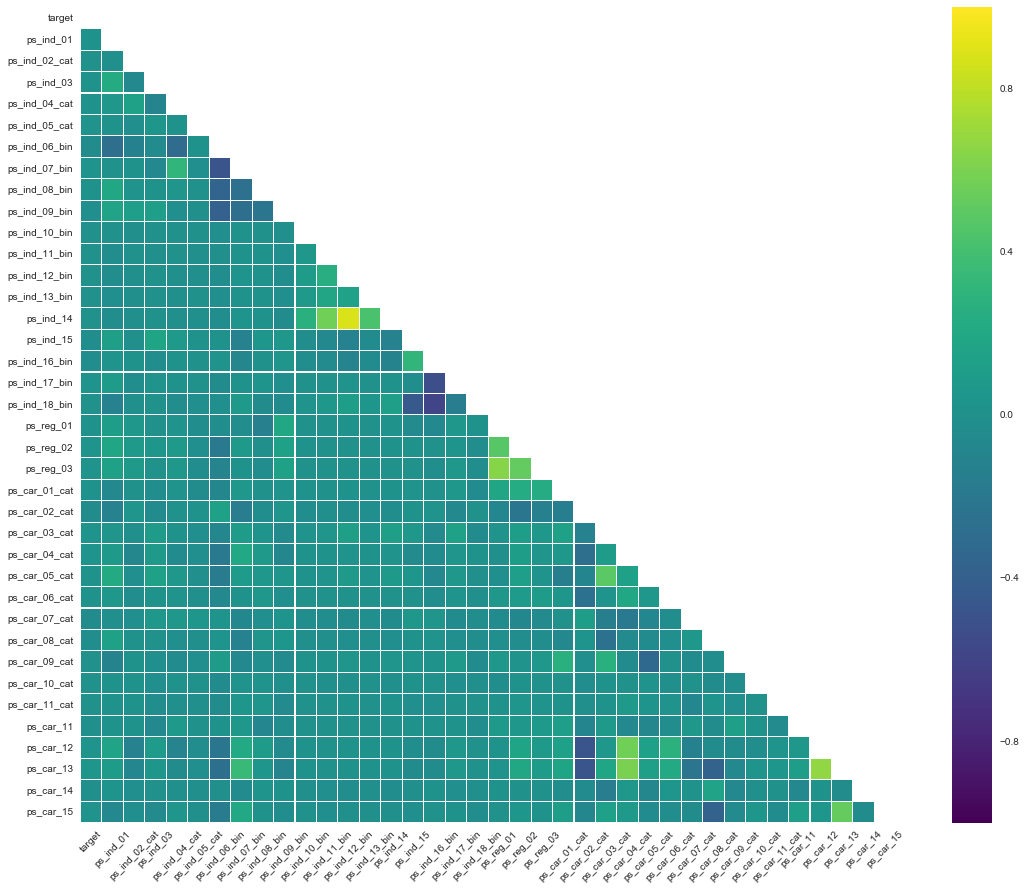

In [80]:
# plot it
mask = np.zeros_like(corr_matrix_sub) # array of zeroes of same shape as array 
mask[np.triu_indices_from(mask)] = True  #indices for upper triangle 
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix_sub, mask=mask, square=True, cmap='viridis', linewidths=0.1, linecolor='white')
    plt.xticks(rotation=45) 

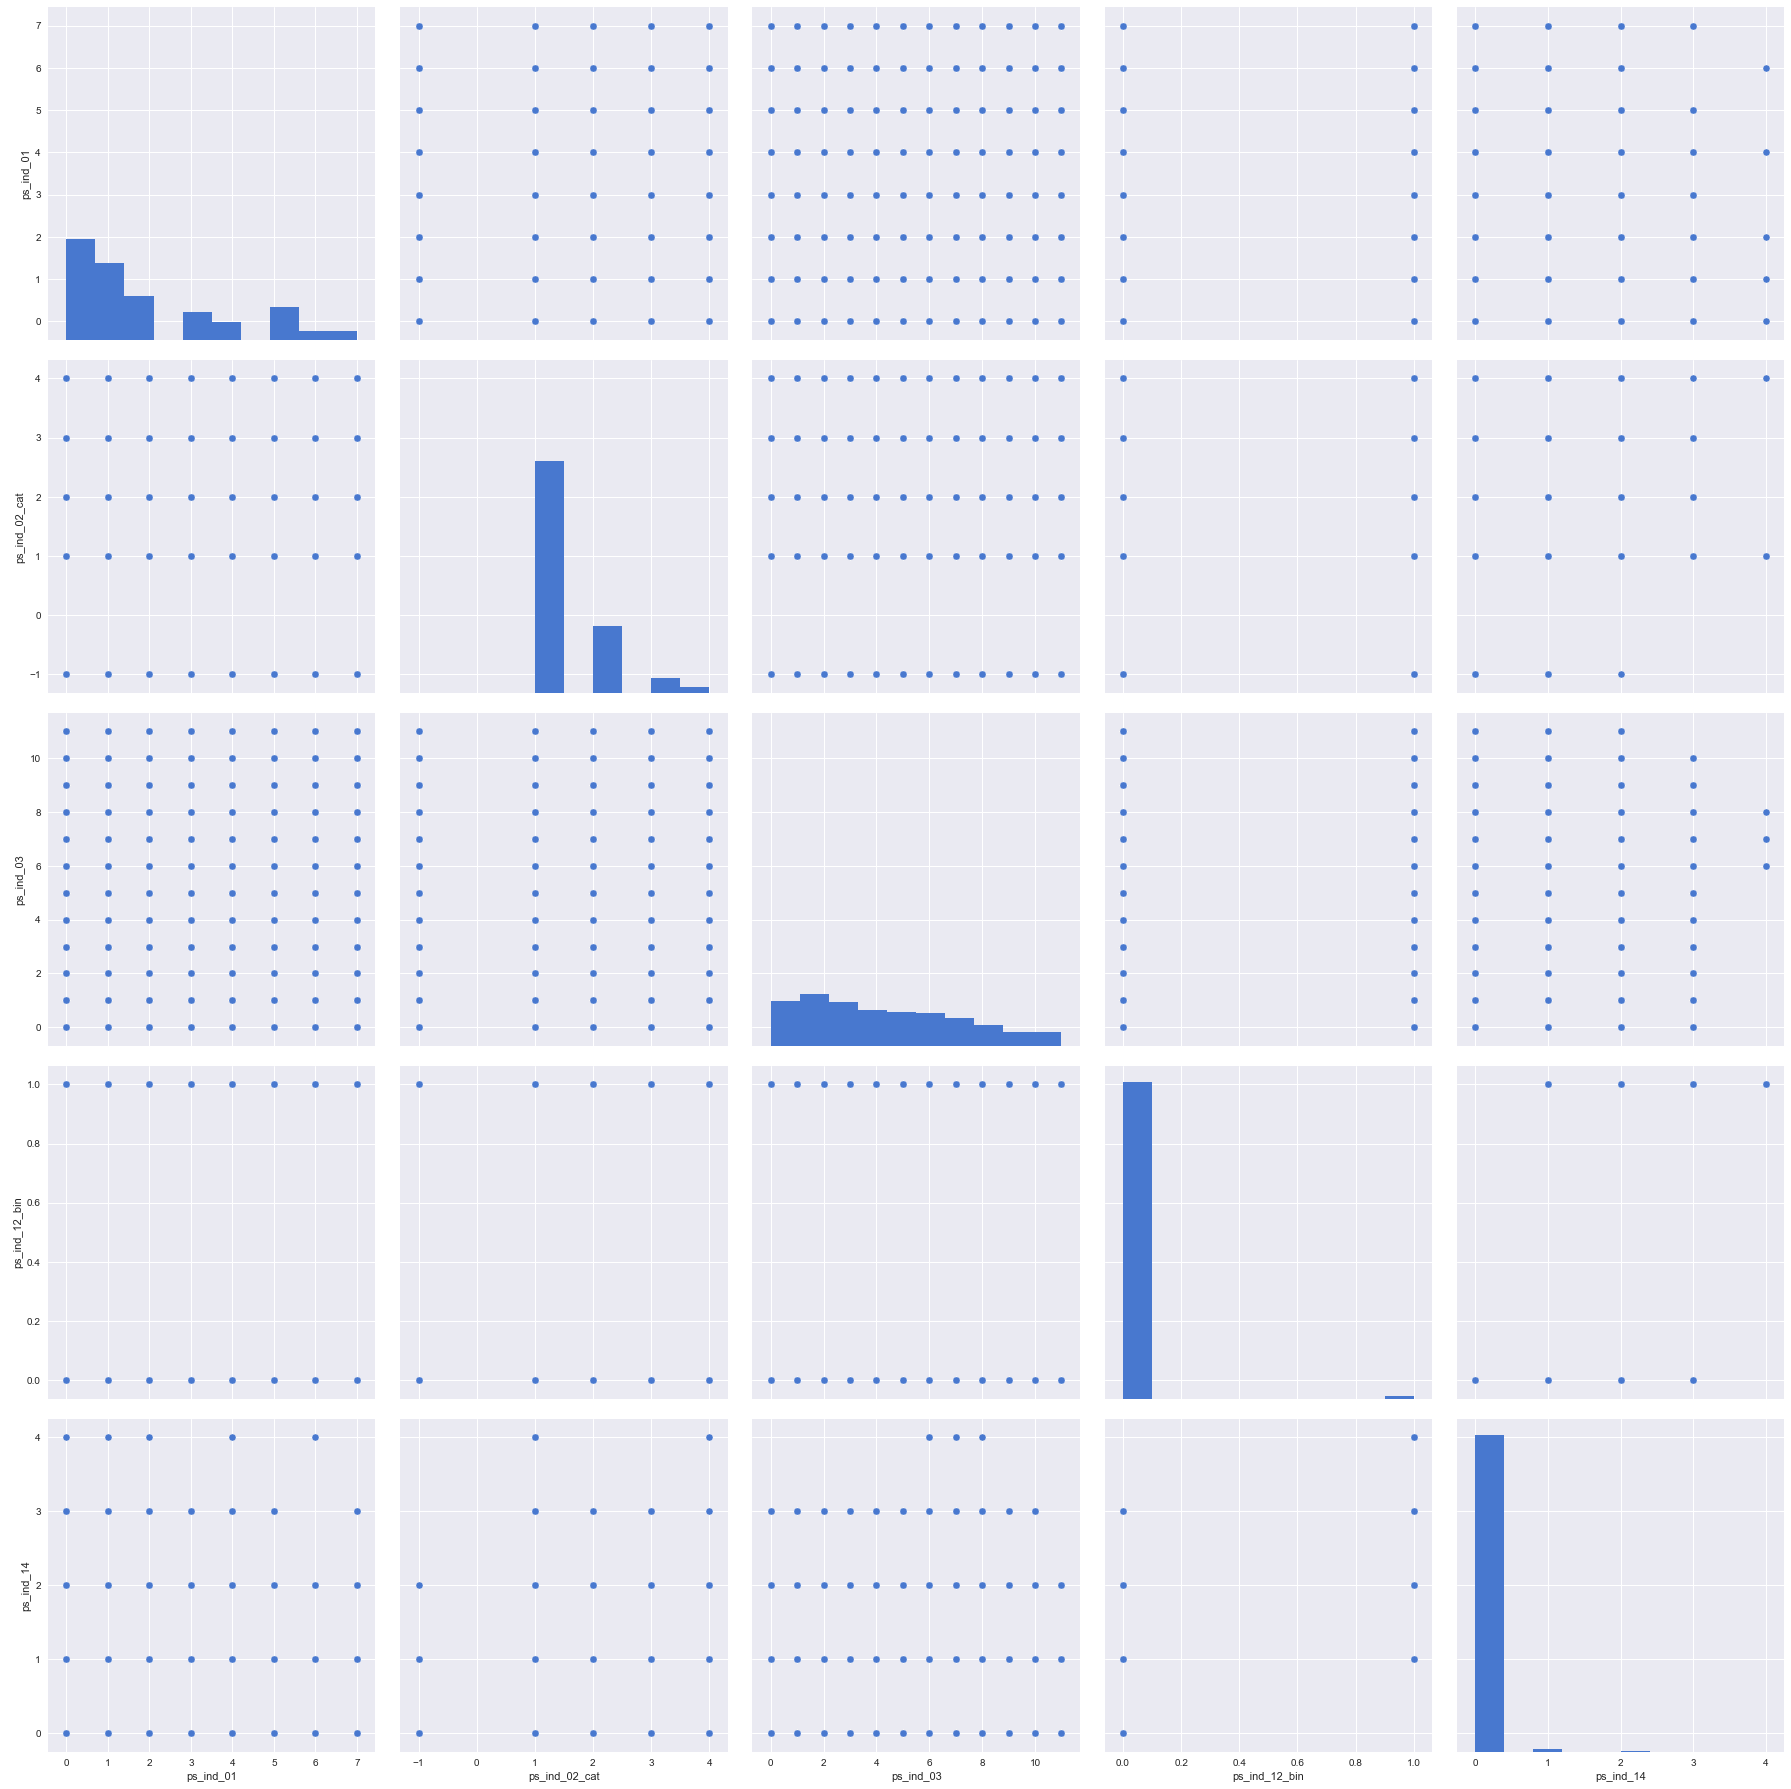

In [82]:
# Selected pairwise distributions -- implies that the features may have already been de-correlated 
sns.pairplot(df1[['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_12_bin', 'ps_ind_14']], size=5)

** Clustering Analysis **

In [83]:
cluster_columns = ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']

In [84]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

insurance_clusters = scaler.fit_transform(df_train[cluster_columns])
insurance_clusters = pd.DataFrame(insurance_clusters, columns=cluster_columns)

In [85]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=15)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['cluster'] = clusters
    return cluster_results

In [86]:
def summarize_clustering(results):
    cluster_size = results.groupby(['cluster']).size().reset_index()
    cluster_size.columns = ['cluster', 'count']
    cluster_means = results.groupby(['cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='cluster')
    return cluster_summary

In [87]:
cluster_results = kmeans_cluster(insurance_clusters, 10)
cluster_summary = summarize_clustering(cluster_results)
cluster_summary

,cluster,count,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
0,0,63632,0.253233,0.363119,0.338073,0.814936,0.070523,0.000000,0.757308,0.242692,...,0.963619,0.835979,0.420178,0.497627,0.601575,0.845418,0.303570,0.226857,0.286440,0.866380
1,1,57826,0.197183,0.302355,0.445941,0.238267,0.074079,0.999620,0.000000,0.000346,...,0.949850,0.736295,0.442167,0.493636,0.580481,0.809399,0.289586,0.205618,0.163851,0.803206
2,2,68534,0.430810,0.341943,0.452032,0.407856,0.075033,0.233475,0.000000,0.427248,...,0.944626,0.928036,0.093184,0.497709,0.604436,0.696992,0.303224,0.207794,0.321916,0.756317
3,3,104139,0.171814,0.317912,0.367545,0.238201,0.075562,1.000000,0.000000,0.000000,...,0.953476,0.882244,0.387626,0.493758,0.584241,0.800462,0.286721,0.197465,0.310247,0.788445
4,4,46942,0.329629,0.333758,0.395887,0.697606,0.060379,0.000000,1.000000,0.000000,...,0.968855,0.853095,0.124036,0.498764,0.626701,0.757786,0.320865,0.251735,0.284857,0.861483
5,5,72427,0.313752,0.375326,0.416786,0.320212,0.062635,0.000000,0.000000,0.187941,...,0.941141,0.895522,0.375595,0.495230,0.572633,0.763656,0.297618,0.209377,0.330394,0.823957
6,6,74640,0.364316,0.356940,0.455594,0.566184,0.068386,0.000523,0.439992,0.315086,...,0.964831,0.647736,0.441707,0.498988,0.598489,0.829484,0.307507,0.240869,0.190231,0.892283
7,7,54504,0.172981,0.319710,0.372350,0.191582,0.067720,0.734368,0.082985,0.160098,...,0.927198,0.876670,0.396792,0.493101,0.588801,0.774255,0.292778,0.202523,0.319466,0.786692
8,8,13171,0.233012,0.371764,0.274922,0.342495,-0.027801,0.196265,0.610888,0.114646,...,-0.872219,0.609369,0.425290,0.498026,0.763736,0.814314,0.347693,0.334922,0.173789,0.882341
9,9,39397,0.222573,0.336777,0.408674,0.419753,0.066325,0.349417,0.315963,0.138538,...,0.930934,0.887200,0.138615,0.496611,0.615383,0.711315,0.303984,0.217361,0.283202,0.786399


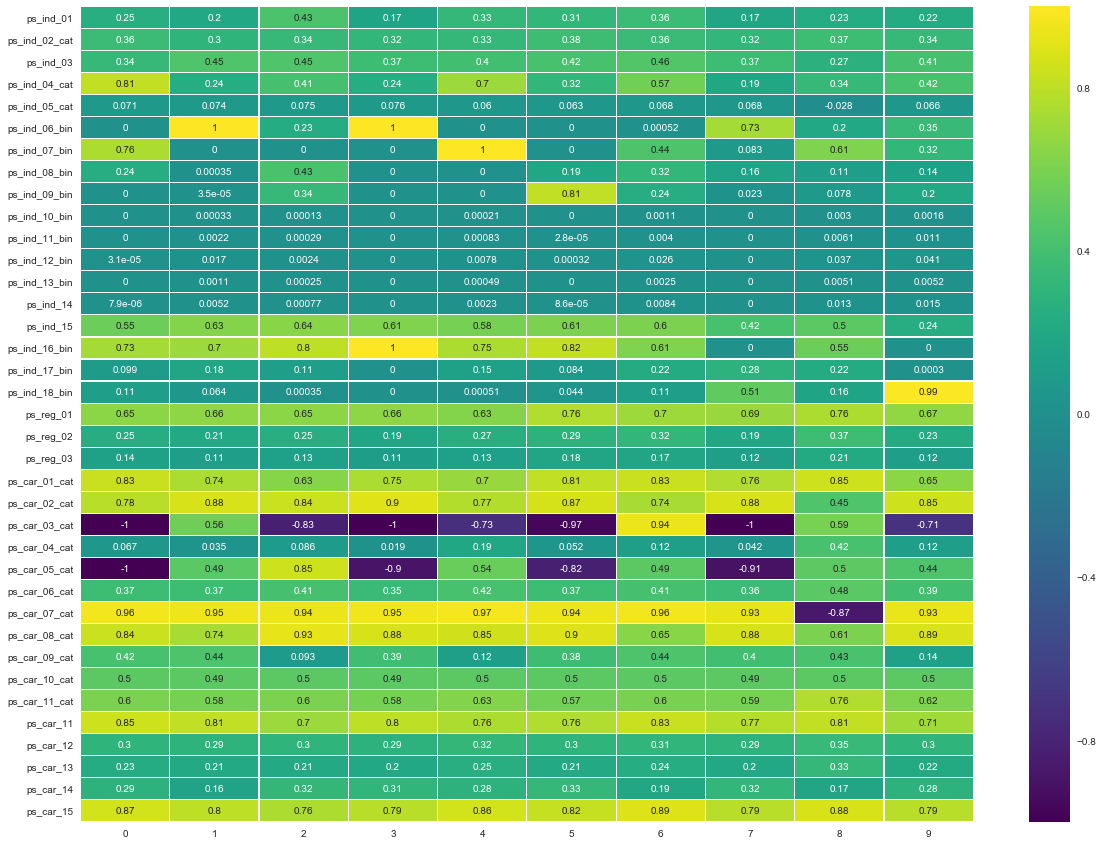

In [88]:
sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True, cmap='viridis', linewidths=0.1, linecolor='white')

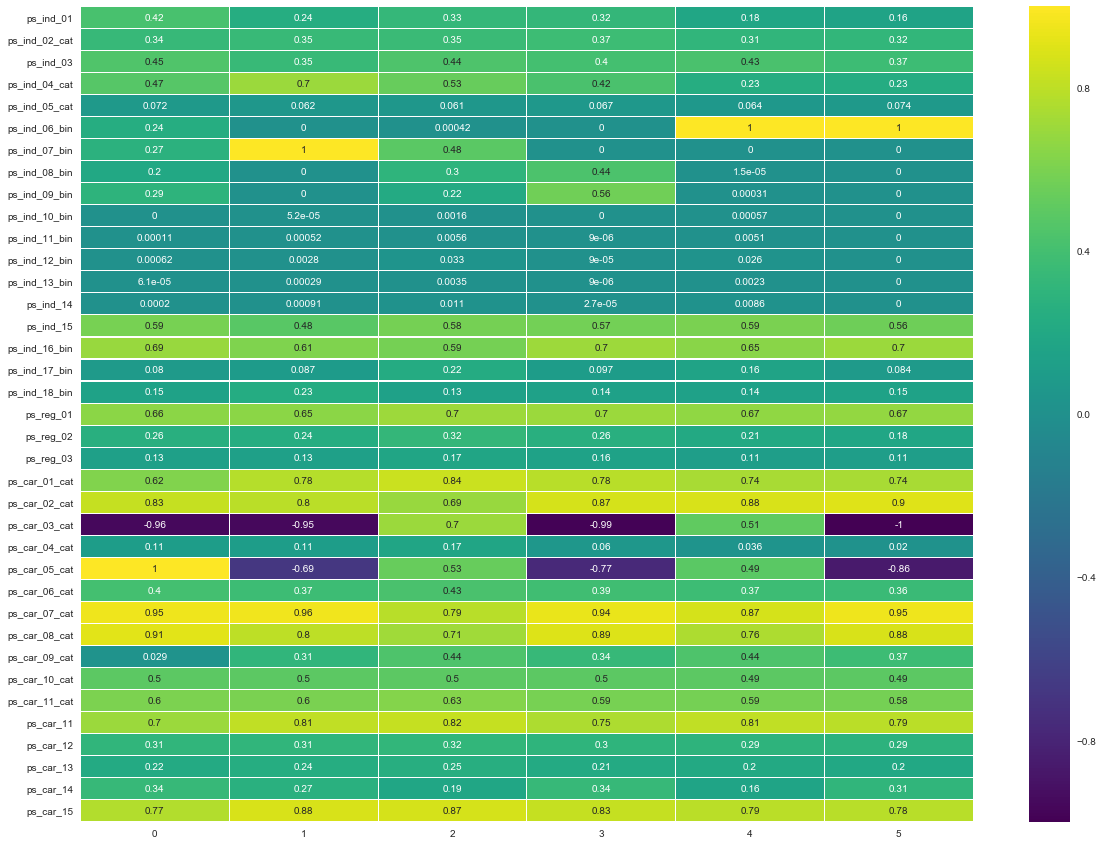

In [89]:
# Cut down the number of clusters 
cluster_results = kmeans_cluster(insurance_clusters,6)
cluster_summary = summarize_clustering(cluster_results)

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True, cmap='viridis', linewidths=0.1, linecolor='white')

In [90]:
cluster_results['cluster'][:10]

0    0
1    3
2    3
3    4
4    5
5    3
6    0
7    4
8    0
9    2
Name: cluster, dtype: int32

In [97]:
df_train['ps_cluster_cat']= cluster_results['cluster']

In [98]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_cluster_cat
0,7,0,2,2,5,1,0,0,1,0,...,1,5,8,0,1,1,0,0,1,0
1,9,0,1,1,7,0,0,0,0,1,...,1,1,9,0,1,1,0,1,0,3
2,13,0,5,4,9,1,0,0,0,1,...,2,7,7,0,1,1,0,1,0,3
3,16,0,0,1,2,0,0,1,0,0,...,2,4,9,0,0,0,0,0,0,4
4,17,0,0,2,0,1,0,1,0,0,...,1,1,3,0,0,0,1,1,0,5


Additional Exploration by Feature Type and Category... 

In [99]:
# Type 
binary_feat = [c for c in df_train.columns if c.endswith("bin")]
categorical_feat = [c for c in df_train.columns if c.endswith("cat")]
continuous_feat = [c for c in df_train.columns if ((c not in binary_feat) & (c not in categorical_feat))]

# Category 
ind_feat = [c for c in df_train.columns if c.startswith("ps_ind")]
reg_feat = [c for c in df_train.columns if c.startswith("ps_reg")]
car_feat = [c for c in df_train.columns if c.startswith("ps_car")]
calc_feat = [c for c in df_train.columns if c.startswith("ps_calc")]

# Target
target = ['target']

In [101]:
# Check 
print("Binary feat :", binary_feat)
print("-" * 60)
print("Categorical feat : ", categorical_feat)
print("-" * 60)
print("Ind feat :", ind_feat)
print("-" * 60)
print("Reg feat : ", reg_feat)
print("-" * 60)
print("Car feat :", car_feat)
print("-" * 60)
print("Calc feat : ", calc_feat)


Binary feat : ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
------------------------------------------------------------
Categorical feat :  ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_cluster_cat']
------------------------------------------------------------
Ind feat : ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_in

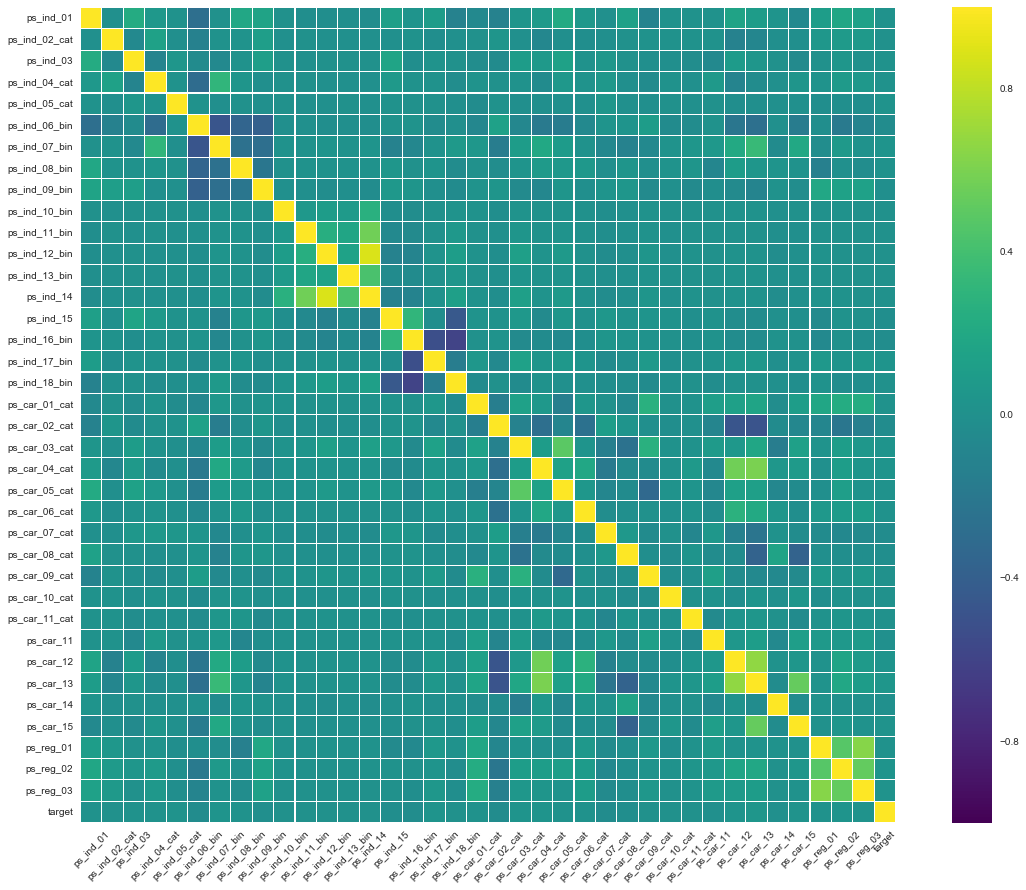

In [105]:
# Heatmap with calculated columns removed 
sns.heatmap(df_train[ind_feat + car_feat + reg_feat + target].corr(), square=True, cmap='viridis', linewidths=0.1, linecolor='white')
plt.xticks(rotation=45)
plt.show()

** Data Prep **

Start by merging the train and test datasets in order to align all data transformations; will extract train and test data later;
through previous preliminary data processing and modeling, found that: (1) the "calculated" features decreased model results; (2) changing dtypes to "category" also hurt results, as did (3) binarization.

In [485]:
# Read clean train dataset back in 
#df_train=pd.read_csv('train.csv')
df_train.shape

(595212, 59)

In [486]:
# Add a dummy target value to df_test to align with df_train 
df_test['target']=-1

In [487]:
df_test.shape

(892816, 59)

In [488]:
# Merge df_train and df_test 
df_train_test=df_train.append(df_test, ignore_index=True)

In [489]:
df_train_test.shape

(1488028, 59)

In [490]:
df_train_test.tail(2)

,id,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,...,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,target
1488026,1488025,0.1,0.1,0.3,1,1,9,2,10,1,...,0,0,13,1,0,0,0.6,0.6,0.920937,-1
1488027,1488026,0.4,0.4,0.2,3,4,7,2,8,4,...,0,0,12,1,0,0,0.9,0.8,0.992157,-1


In [491]:
df_train_test.dtypes

id                  int64
ps_calc_01        float64
ps_calc_02        float64
ps_calc_03        float64
ps_calc_04          int64
ps_calc_05          int64
ps_calc_06          int64
ps_calc_07          int64
ps_calc_08          int64
ps_calc_09          int64
ps_calc_10          int64
ps_calc_11          int64
ps_calc_12          int64
ps_calc_13          int64
ps_calc_14          int64
ps_calc_15_bin      int64
ps_calc_16_bin      int64
ps_calc_17_bin      int64
ps_calc_18_bin      int64
ps_calc_19_bin      int64
ps_calc_20_bin      int64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11           int64
ps_car_11_cat       int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15         float64
ps_ind_01           int64
ps_ind_02_ca

In [525]:
# df_train_test.to_csv("train_test_unprocessed", index=False)
df_train_test=pd.read_csv("train_test_unprocessed")

Remove "calculated" features 

In [526]:
calc_cols=['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin']

In [527]:
df_train_test.drop(calc_cols, axis=1, inplace=True)

In [528]:
df_train_test.head()

,id,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,...,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,target
0,7,10,1,-1,0,1,4,1,0,0,...,0,0,11,0,1,0,0.7,0.2,0.718070,0
1,9,11,1,-1,0,-1,11,1,1,2,...,0,0,3,0,0,1,0.8,0.4,0.766078,0
2,13,7,1,-1,0,-1,14,1,1,2,...,0,0,12,1,0,0,0.0,0.0,-1.000000,0
3,16,7,1,0,0,1,11,1,1,3,...,0,0,8,1,0,0,0.9,0.2,0.580948,0
4,17,11,1,-1,0,-1,14,1,1,2,...,0,0,9,1,0,0,0.7,0.6,0.840759,0


Next, undo binarization

In [529]:
# Determine unique values by column 
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(df_train_test)

id | 1488028 | int64
ps_car_01_cat | 13 | int64
ps_car_02_cat | 3 | int64
ps_car_03_cat | 3 | int64
ps_car_04_cat | 10 | int64
ps_car_05_cat | 3 | int64
ps_car_06_cat | 18 | int64
ps_car_07_cat | 3 | int64
ps_car_08_cat | 2 | int64
ps_car_09_cat | 6 | int64
ps_car_10_cat | 3 | int64
ps_car_11 | 5 | int64
ps_car_11_cat | 104 | int64
ps_car_12 | 214 | float64
ps_car_13 | 104192 | float64
ps_car_14 | 905 | float64
ps_car_15 | 15 | float64
ps_ind_01 | 8 | int64
ps_ind_02_cat | 5 | int64
ps_ind_03 | 12 | int64
ps_ind_04_cat | 3 | int64
ps_ind_05_cat | 8 | int64
ps_ind_06_bin | 2 | int64
ps_ind_07_bin | 2 | int64
ps_ind_08_bin | 2 | int64
ps_ind_09_bin | 2 | int64
ps_ind_10_bin | 2 | int64
ps_ind_11_bin | 2 | int64
ps_ind_12_bin | 2 | int64
ps_ind_13_bin | 2 | int64
ps_ind_14 | 5 | int64
ps_ind_15 | 14 | int64
ps_ind_16_bin | 2 | int64
ps_ind_17_bin | 2 | int64
ps_ind_18_bin | 2 | int64
ps_reg_01 | 10 | float64
ps_reg_02 | 19 | float64
ps_reg_03 | 5077 | float64
target | 3 | int64


In [530]:
bin_cols=[c for c in df_train_test.columns if c.endswith("bin")]
print(bin_cols)

['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


In [531]:
df_bin_cols=df_train_test[bin_cols]
df_bin_cols.head(2)

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,1


In [532]:
bin_percentages=(df_bin_cols==1).sum()/len(df_bin_cols)
bin_percentages=round(bin_percentages, 3)
print("Percentage of column values with 1s(positives) : ", bin_percentages)

Percentage of column values with 1s(positives) :  ps_ind_06_bin    0.393
ps_ind_07_bin    0.257
ps_ind_08_bin    0.164
ps_ind_09_bin    0.186
ps_ind_10_bin    0.000
ps_ind_11_bin    0.002
ps_ind_12_bin    0.009
ps_ind_13_bin    0.001
ps_ind_16_bin    0.661
ps_ind_17_bin    0.121
ps_ind_18_bin    0.154
dtype: float64


In [533]:
# Checking the feature showing 0.000% 1's to make sure there are some 1s
df_train_test.ps_ind_10_bin.value_counts()

0    1487473
1        555
Name: ps_ind_10_bin, dtype: int64

ps_ind_06_bin to ps_ind_09_bin add to 1, indicating that these were categoricals made binary; I will undo that and create a new column to hold values 1 to 4; the others will remain binary, as there are no indications thay have been binarized from a categorical 

In [534]:
# Create a new column to hold the un-binarized values 
df_train_test['ps_ind_6_to_9_cat']=0

In [535]:
df_train_test['ps_ind_6_to_9_cat']=np.where(df_train_test.ps_ind_06_bin==1, 1, df_train_test.ps_ind_6_to_9_cat)
df_train_test['ps_ind_6_to_9_cat']=np.where(df_train_test.ps_ind_07_bin==1, 2, df_train_test.ps_ind_6_to_9_cat)
df_train_test['ps_ind_6_to_9_cat']=np.where(df_train_test.ps_ind_08_bin==1, 3, df_train_test.ps_ind_6_to_9_cat)
df_train_test['ps_ind_6_to_9_cat']=np.where(df_train_test.ps_ind_09_bin==1, 4, df_train_test.ps_ind_6_to_9_cat)

In [536]:
df_train_test['ps_ind_6_to_9_cat'].value_counts()

1    585456
2    382613
4    276274
3    243685
Name: ps_ind_6_to_9_cat, dtype: int64

In [537]:
df_train_test.drop(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin'], axis=1, inplace=True)

In [538]:
df_train_test.shape

(1488028, 36)

In [588]:
# df_train_test.to_csv('train_test_processed_vR1', index=False)
df_train_test=pd.read_csv('train_test_processed_vR1')

Now, look at remaining columns with high Nan's (in this case, -1s were used for missing values)

In [555]:
# No NaNs, but data description said NaNs were replaced by -1; here are those percentages; ps_reg_03 has about 1 in 5 missing 
percentages=(df_train_test== -1).sum() / len(df_train_test)
percentages=round(percentages, 3)
print("Percentage of column values with Nan's (-1s) : ", percentages)

Percentage of column values with Nan's (-1s) :  id                   0.000
ps_car_01_cat        0.000
ps_car_02_cat        0.000
ps_car_03_cat        0.691
ps_car_04_cat        0.000
ps_car_05_cat        0.448
ps_car_06_cat        0.000
ps_car_07_cat        0.019
ps_car_08_cat        0.000
ps_car_09_cat        0.001
ps_car_10_cat        0.000
ps_car_11            0.000
ps_car_11_cat        0.000
ps_car_12            0.000
ps_car_13            0.000
ps_car_14            0.072
ps_car_15            0.000
ps_ind_01            0.000
ps_ind_02_cat        0.000
ps_ind_03            0.000
ps_ind_04_cat        0.000
ps_ind_05_cat        0.010
ps_ind_10_bin        0.000
ps_ind_11_bin        0.000
ps_ind_12_bin        0.000
ps_ind_13_bin        0.000
ps_ind_14            0.000
ps_ind_15            0.000
ps_ind_16_bin        0.000
ps_ind_17_bin        0.000
ps_ind_18_bin        0.000
ps_reg_01            0.000
ps_reg_02            0.000
ps_reg_03            0.181
target               0.600
ps_ind_

In [556]:
x=percentages.loc[percentages>0.001]
x

ps_car_03_cat    0.691
ps_car_05_cat    0.448
ps_car_07_cat    0.019
ps_car_14        0.072
ps_ind_05_cat    0.010
ps_reg_03        0.181
target           0.600
dtype: float64

In [557]:
cols_with_nans=x.index.values
cols_with_nans=list(cols_with_nans)
cols_with_nans.remove('target')
cols_with_nans

['ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_14',
 'ps_ind_05_cat',
 'ps_reg_03']

In [558]:
df_nan=df_train_test[cols_with_nans]

In [559]:
df_nan.head()

,ps_car_03_cat,ps_car_05_cat,ps_car_07_cat,ps_car_14,ps_ind_05_cat,ps_reg_03
0,-1,1,1,0.370810,0,0.718070
1,-1,-1,1,0.388716,0,0.766078
2,-1,-1,1,0.347275,0,-1.000000
3,0,1,1,0.294958,0,0.580948
4,-1,-1,1,0.365103,0,0.840759


In [560]:
df_nan.describe()

,ps_car_03_cat,ps_car_05_cat,ps_car_07_cat,ps_car_14,ps_ind_05_cat,ps_reg_03
count,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06
mean,-5.048964e-01,-1.581623e-01,9.100971e-01,2.763614e-01,4.069547e-01,5.514848e-01
std,7.887134e-01,8.445060e-01,3.472121e-01,3.569623e-01,1.353300e+00,7.938159e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-1.000000e+00,-1.000000e+00,1.000000e+00,3.339162e-01,0.000000e+00,5.250000e-01
50%,-1.000000e+00,0.000000e+00,1.000000e+00,3.687818e-01,0.000000e+00,7.211103e-01
75%,0.000000e+00,1.000000e+00,1.000000e+00,3.964846e-01,0.000000e+00,1.001561e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,6.363961e-01,6.000000e+00,4.423517e+00


In [561]:
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488028 entries, 0 to 1488027
Data columns (total 6 columns):
ps_car_03_cat    1488028 non-null int64
ps_car_05_cat    1488028 non-null int64
ps_car_07_cat    1488028 non-null int64
ps_car_14        1488028 non-null float64
ps_ind_05_cat    1488028 non-null int64
ps_reg_03        1488028 non-null float64
dtypes: float64(2), int64(4)
memory usage: 68.1 MB


In [562]:
for c in df_nan: 
    print(c)
    print('Number of missing values: ', (df_nan[c]== -1).sum())
    print('dtype : ', df_nan[c].dtype)
    print('Unique values : ', df_nan[c].nunique())
    print('--'*60)

ps_car_03_cat
Number of missing values:  1028142
dtype :  int64
Unique values :  3
------------------------------------------------------------------------------------------------------------------------
ps_car_05_cat
Number of missing values:  666910
dtype :  int64
Unique values :  3
------------------------------------------------------------------------------------------------------------------------
ps_car_07_cat
Number of missing values:  28820
dtype :  int64
Unique values :  3
------------------------------------------------------------------------------------------------------------------------
ps_car_14
Number of missing values:  106425
dtype :  float64
Unique values :  905
------------------------------------------------------------------------------------------------------------------------
ps_ind_05_cat
Number of missing values:  14519
dtype :  int64
Unique values :  8
-----------------------------------------------------------------------------------------------------------

Impute missing values using RandomForest Classifier or Regressor 

In [563]:
X=df_train_test

In [564]:
# Instantiate needed algortihms 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rfC=RandomForestClassifier(class_weight='balanced')
rfR=RandomForestRegressor()

# Define the value imputation function 
def impute_missing_vals(alg, X, y) :
    """Imputes the missing values for a feature using a machine learning algorithm.
       returns a dataframe with the id of each row and the imputed value"""

    X1= X.loc[X[y]!=-1]            # Put all non-Nan valued rows for this column in a dataframe, minus the target values; these will be used to fit the model  
    y1=X1[y]                       # Assign the known target values to y, for model fitting   
    X1=X1.drop([y, 'id', 'target'], axis=1)  # Remove 'id,' meta 'target', and the column to be predicted 
    X2=X.loc[X[y]==-1]             # Put the Nan-valued rows into a df for prediction 
    X3=X2.drop([y, 'id', 'target'], axis=1)  # drop the non-predictors 

    alg.fit(X1, y1)  # fit the algorithm to the data 
    predictions= alg.predict(X3) # predict the missing target values 
    new_col=y + '_imp' # assign a nw column name for imputed values
    X2[new_col]=predictions  # append the predictions to the new column 
    X2=X2[['id', new_col]]  # return a df with just id and predictions 

    return X2

In [565]:
# Impute the first feature values 
targ_col='ps_car_05_cat'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfC, X, targ_col) # Assign the results of function impute_missing_values to vals
df_train_test=df_train_test.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df_train_test[targ_col]=np.where(df_train_test[targ_col]==-1, df_train_test[new_col], df_train_test[targ_col]) # where there is a missing value, assign the imputed value 
df_train_test.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df_train_test[targ_col].head(10) # checks       

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
5    0.0
6    1.0
7    0.0
8    1.0
9    0.0
Name: ps_car_05_cat, dtype: float64

In [566]:
# Impute the second feature values 
targ_col='ps_car_03_cat'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfC, X, targ_col) # Assign the results of function impute_missing_values to vals
df_train_test=df_train_test.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df_train_test[targ_col]=np.where(df_train_test[targ_col]==-1, df_train_test[new_col], df_train_test[targ_col]) # where there is a missing value, assign the imputed value 
df_train_test.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df_train_test[targ_col].head(10) # checks       

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    1.0
9    0.0
Name: ps_car_03_cat, dtype: float64

In [567]:
# Impute the third feature values 
targ_col='ps_car_07_cat'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfC, X, targ_col) # Assign the results of function impute_missing_values to vals
df_train_test=df_train_test.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df_train_test[targ_col]=np.where(df_train_test[targ_col]==-1, df_train_test[new_col], df_train_test[targ_col]) # where there is a missing value, assign the imputed value 
df_train_test.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df_train_test[targ_col].head(10) # checks       

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: ps_car_07_cat, dtype: float64

In [568]:
# Impute the fourth feature values 
targ_col='ps_ind_05_cat'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfC, X, targ_col) # Assign the results of function impute_missing_values to vals
df_train_test=df_train_test.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df_train_test[targ_col]=np.where(df_train_test[targ_col]==-1, df_train_test[new_col], df_train_test[targ_col]) # where there is a missing value, assign the imputed value 
df_train_test.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df_train_test[targ_col].head(10) # checks

# Repeat for each column       

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: ps_ind_05_cat, dtype: float64

In [569]:
# Impute the fifth feature values -
targ_col='ps_reg_03'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfR, X, targ_col) # Assign the results of function impute_missing_values to vals
df_train_test=df_train_test.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df_train_test[targ_col]=np.where(df_train_test[targ_col]==-1, df_train_test[new_col], df_train_test[targ_col]) # where there is a missing value, assign the imputed value 
df_train_test.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df_train_test[targ_col].head(10) # checks

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    0.718070
1    0.766078
2    0.812967
3    0.580948
4    0.840759
5    2.332649
6    0.617454
7    0.607248
8    0.901388
9    2.316652
Name: ps_reg_03, dtype: float64

In [570]:
# Impute the sixth feature values 
targ_col='ps_car_14'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfR, X, targ_col) # Assign the results of function impute_missing_values to vals
df_train_test=df_train_test.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df_train_test[targ_col]=np.where(df_train_test[targ_col]==-1, df_train_test[new_col], df_train_test[targ_col]) # where there is a missing value, assign the imputed value 
df_train_test.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df_train_test[targ_col].head(10) # checks

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    0.370810
1    0.388716
2    0.347275
3    0.294958
4    0.365103
5    0.406202
6    0.368782
7    0.374833
8    0.407431
9    0.390256
Name: ps_car_14, dtype: float64

We now have imputed values for the missing feature values

In [571]:
# df_train_test.to_csv('train_test_processed_vR2', index=False)
# # df2=pd.read_csv('train_test_processed_vR2')

Add clusters as features 

In [448]:
cluster_columns = df_train_test.drop(['id', 'target'], axis=1).columns                      
len(cluster_columns)  

34

In [449]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

insurance_clusters = scaler.fit_transform(df_train_test[cluster_columns])
insurance_clusters = pd.DataFrame(insurance_clusters, columns=cluster_columns)

In [450]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=15)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['cluster'] = clusters
    return cluster_results

In [451]:
def summarize_clustering(results):
    cluster_size = results.groupby(['cluster']).size().reset_index()
    cluster_size.columns = ['cluster', 'count']
    cluster_means = results.groupby(['cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='cluster')
    return cluster_summary

In [456]:
# Repeat next two cells for clusters of 10, 50, 100 
cluster_results = kmeans_cluster(insurance_clusters, 100)
cluster_summary = summarize_clustering(cluster_results)
cluster_summary

,cluster,count,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,...,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_ind_6_to_9_cat
0,0,5805,0.912740,0.002412,0.974677,0.947631,0.542119,0.641019,0.961240,0.526615,...,0.003790,0.009475,0.517366,0.000000,0.941602,0.000000,0.784802,0.421926,0.259731,0.558656
1,1,32112,0.743121,1.000000,0.000000,0.015858,0.000000,0.073718,1.000000,1.000000,...,0.000031,0.000623,0.548348,1.000000,0.000000,0.000000,0.846942,0.208864,0.167722,0.422552
2,2,30502,0.836237,1.000000,0.000000,0.022305,1.000000,0.350704,0.974297,0.982886,...,0.000066,0.000746,0.653006,1.000000,0.000000,0.000000,0.895894,0.358896,0.222917,0.616894
3,3,25514,0.834850,1.000000,1.000000,0.024248,0.000000,0.184854,0.974249,1.000000,...,0.000157,0.000901,0.604139,0.944070,0.000000,0.000000,0.880445,0.314668,0.207947,0.581259
4,4,14053,0.866596,1.000000,1.000000,0.095598,1.000000,0.710478,0.957447,0.999787,...,0.000071,0.000623,0.652185,0.999929,0.000000,0.000000,0.864750,0.397717,0.238000,0.879954
5,5,12658,0.732020,0.976774,0.000000,0.066036,1.000000,0.340993,0.931664,0.980882,...,0.001027,0.003377,0.667519,0.000000,0.000000,0.000000,0.652051,0.209200,0.182345,0.484279
6,6,19054,0.690249,0.999895,1.000000,0.017722,0.000000,0.162498,0.983835,1.000000,...,0.000052,0.000735,0.652078,0.937441,0.000000,0.000000,0.282169,0.088646,0.166518,0.525533
7,7,12144,0.770744,1.000000,0.000000,0.008829,1.000000,0.174262,0.953475,0.984766,...,0.001400,0.004241,0.569550,0.000000,1.000000,0.000000,0.735196,0.230992,0.186398,0.496233
8,8,7812,0.626286,0.988991,0.074885,0.144863,0.278930,0.306730,0.000000,0.943420,...,0.007680,0.015489,0.190378,0.000000,0.000000,0.958141,0.712010,0.195796,0.172965,0.495392
9,9,22672,0.697548,0.999471,0.000000,0.055002,1.000000,0.287522,0.999603,0.983857,...,0.000132,0.000474,0.650307,1.000000,0.000000,0.000000,0.224001,0.089212,0.161087,0.405787


In [457]:
df_train_test['ps_cluster100_cat']= cluster_results['cluster']
df_train_test['ps_cluster100_cat'][:10]   

0    38
1    92
2    43
3    45
4     2
5    78
6    13
7    48
8    13
9    59
Name: ps_cluster100_cat, dtype: int32

In [458]:
df_train_test.columns

Index(['id', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',
       'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11',
       'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15',
       'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'target', 'ps_ind_6_to_9_cat', 'ps_cluster10_cat', 'ps_cluster50_cat',
       'ps_cluster100_cat'],
      dtype='object')

In [583]:
# df_train_test.to_csv('train_test_processed_vR3', index=False)
# df_train_test=pd.read_csv('train_test_processed_vR3')

This code was used for iterative modeling on different versions of the data and to identify feature importances.  In the end, 
the dataset minus calculated features and with binarization of one feature reversed yielded the highest predictive score.  Other transformations -- dropping high Nan features, imputing values for high Nan features, and cluster features -- did not add to predictive ability.  

In [589]:
# Revert to "best" dataset
df_train_test=pd.read_csv('train_test_processed_vR1')

In [590]:
df_train=df_train_test.loc[df_train_test['target']!= -1]
df_test=df_train_test.loc[df_train_test['target'] == -1]

In [591]:
X = df_train.drop(['id', 'target'], axis=1)
y = df_train['target']
train_columns=df_train.drop(['id', 'target'], axis=1).columns
print(X.shape, y.shape)

(595212, 34) (595212,)


In [592]:
from sklearn import cross_validation, metrics 

def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    y_pred_binary = alg.predict(X)
    y_pred_proba = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y, y_pred_binary))
    # CV ROC-AUC scores align much better with the Kaggle competition 
#     print ("Model's ROC_AUC Score : %.4g" % metrics.roc_auc_score(y, y_pred_proba))
#     print ("Model's Gini score : %.4g" % gini(y, y_pred_proba))
  
    
    
    if performCV:
        print ("CV AUC Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),                                                                            
                                                    np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        # Added 
        print ("CV Gini score : %.4g" % (2*np.mean(cv_score)-1))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, train_columns).sort_values(ascending=True)
        feat_imp.plot(kind='barh', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [593]:
lgb_model = lgb.LGBMClassifier(is_unbalance=True)


Model Report
Accuracy : 0.6018
CV AUC Score : Mean - 0.6288 | Std - 0.002051 | Min - 0.6255 | Max - 0.631
CV Gini score : 0.2577


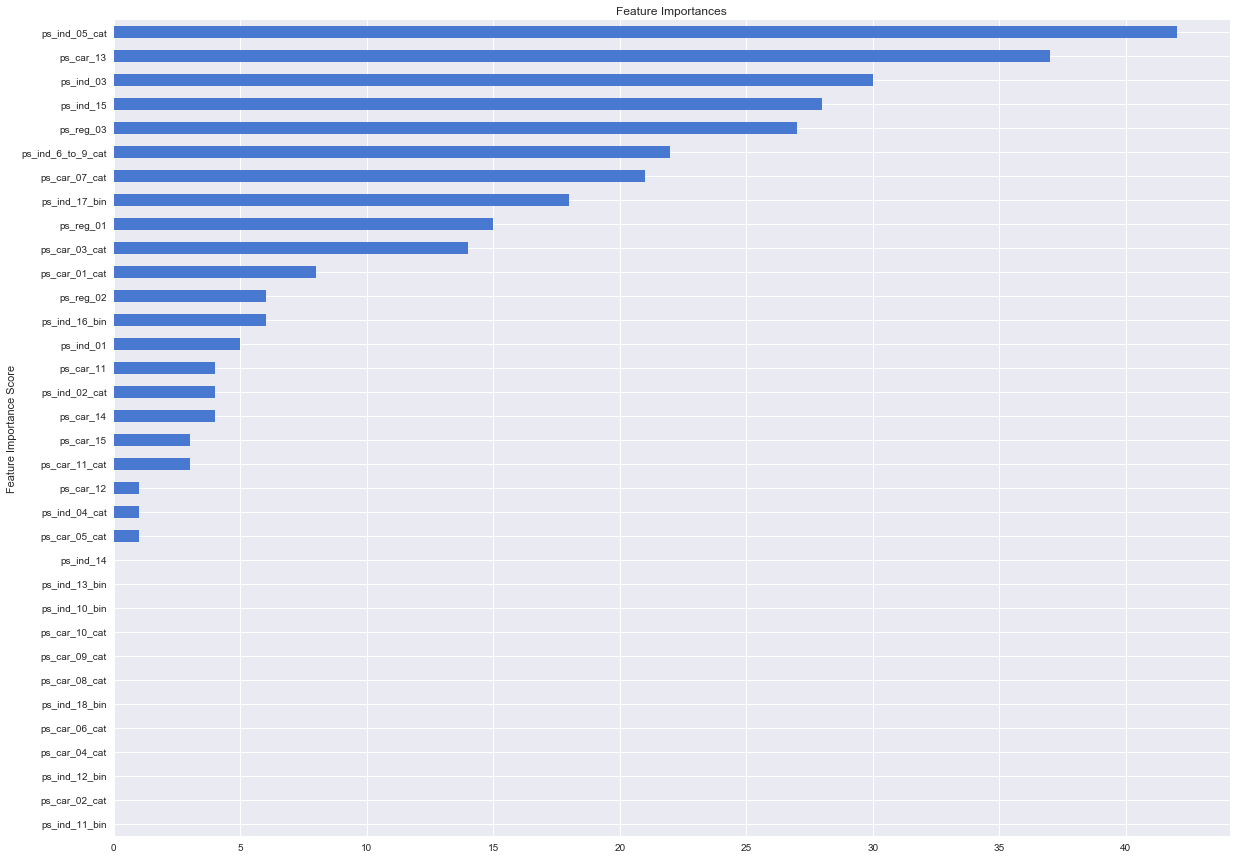

In [594]:
# Baseline LGB model 
modelfit(lgb_model, X, y)

** Modeling Tuning **

After signifcant experimentation with different models and parameters, the LightGBM model delivered the best predictive results.
Below, I tune the LightGBM model. 

In [598]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, auc

In [599]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

In [600]:
def gini(truth, predictions):
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

def gini_lgb(truth, predictions):
    score = gini(truth, predictions) / gini(truth, truth)
    return 'gini', score, True

def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

In [602]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
#         'reg_lambda': int(params['reg_lambda']),
#         'reg_alpha': '{:.2f}'.format(params['reg_alpha'])
#         'n_estimators': int(params['n_estimators']),
#         'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
         n_estimators=500,
         learning_rate=0.01,
#         num_leaves=24,
#         colsample_bytree=0.898,
#         reg_alpha=0.84, 
#         reg_lambda=1, 
        is_unbalance=True,
        **params
        )
    
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
#     'reg_alpha': hp.quniform('reg_alpha', 0.00, 1.00, 0.02),
#     'reg_lambda': hp.quniform('reg_lambda', 0, 6, 1)
#     'n_estimators': hp.uniform('n_estimators', 500, 2400),
#     'learning_rate': hp.uniform('learning_rate', 0.003, 0.01)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=15)

Gini -0.2779 params {'num_leaves': 16, 'colsample_bytree': '0.7594'}
Gini -0.2739 params {'num_leaves': 10, 'colsample_bytree': '0.8740'}
Gini -0.2763 params {'num_leaves': 124, 'colsample_bytree': '0.6986'}
Gini -0.2774 params {'num_leaves': 118, 'colsample_bytree': '0.6642'}
Gini -0.2587 params {'num_leaves': 76, 'colsample_bytree': '0.3566'}
Gini -0.2587 params {'num_leaves': 78, 'colsample_bytree': '0.3613'}
Gini -0.2794 params {'num_leaves': 76, 'colsample_bytree': '0.5173'}
Gini -0.2791 params {'num_leaves': 102, 'colsample_bytree': '0.6124'}
Gini -0.2796 params {'num_leaves': 46, 'colsample_bytree': '0.8947'}
Gini -0.2774 params {'num_leaves': 118, 'colsample_bytree': '0.6718'}
Gini -0.2781 params {'num_leaves': 60, 'colsample_bytree': '0.4659'}
Gini -0.2783 params {'num_leaves': 110, 'colsample_bytree': '0.5414'}
Gini -0.2789 params {'num_leaves': 74, 'colsample_bytree': '0.7400'}
Gini -0.2764 params {'num_leaves': 96, 'colsample_bytree': '0.8640'}
Gini -0.2798 params {'num_lea

In [603]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.5451943721319141, 'num_leaves': 64.0}


In [604]:
def objective(params):
    params = {
#         'num_leaves': int(params['num_leaves']),
#         'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
        'reg_lambda': int(params['reg_lambda']),
        'reg_alpha': '{:.2f}'.format(params['reg_alpha'])
#         'n_estimators': int(params['n_estimators']),
#         'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
         n_estimators=500,
         learning_rate=0.01,
         num_leaves=64,
         colsample_bytree=0.55,
#         reg_alpha=0.84, 
#         reg_lambda=1, 
        is_unbalance=True,
        **params
        )
    
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
#     'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
    'reg_alpha': hp.quniform('reg_alpha', 0.00, 1.00, 0.02),
    'reg_lambda': hp.quniform('reg_lambda', 0, 6, 1)
#     'n_estimators': hp.uniform('n_estimators', 500, 2400),
#     'learning_rate': hp.uniform('learning_rate', 0.003, 0.01)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=15)

Gini -0.2810 params {'reg_lambda': 5, 'reg_alpha': '0.80'}
Gini -0.2807 params {'reg_lambda': 4, 'reg_alpha': '0.04'}
Gini -0.2808 params {'reg_lambda': 3, 'reg_alpha': '0.98'}
Gini -0.2805 params {'reg_lambda': 3, 'reg_alpha': '0.80'}
Gini -0.2802 params {'reg_lambda': 1, 'reg_alpha': '0.18'}
Gini -0.2806 params {'reg_lambda': 1, 'reg_alpha': '0.90'}
Gini -0.2812 params {'reg_lambda': 3, 'reg_alpha': '0.62'}
Gini -0.2802 params {'reg_lambda': 2, 'reg_alpha': '0.44'}
Gini -0.2809 params {'reg_lambda': 4, 'reg_alpha': '0.16'}
Gini -0.2807 params {'reg_lambda': 2, 'reg_alpha': '0.56'}
Gini -0.2809 params {'reg_lambda': 3, 'reg_alpha': '0.08'}
Gini -0.2811 params {'reg_lambda': 5, 'reg_alpha': '0.94'}
Gini -0.2802 params {'reg_lambda': 1, 'reg_alpha': '0.14'}
Gini -0.2810 params {'reg_lambda': 3, 'reg_alpha': '0.56'}
Gini -0.2800 params {'reg_lambda': 1, 'reg_alpha': '0.74'}


In [605]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'reg_alpha': 0.62, 'reg_lambda': 3.0}


In [606]:
def objective(params):
    params = {
#         'num_leaves': int(params['num_leaves']),
# #       'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
#         'reg_lambda': int(params['reg_lambda']),
#         'reg_alpha': '{:.2f}'.format(params['reg_alpha'])
        'n_estimators': int(params['n_estimators']),
        'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
#          n_estimators=500,
#          learning_rate=0.01,
         num_leaves=64,
         colsample_bytree=0.55,
         reg_alpha=0.62, 
         reg_lambda=3, 
         is_unbalance=True,
         **params
        )
     
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
#     'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
#     'reg_alpha': hp.quniform('reg_alpha', 0.00, 1.00, 0.02),
#     'reg_lambda': hp.quniform('reg_lambda', 0, 6, 1)
    'n_estimators': hp.uniform('n_estimators', 400, 2400),
    'learning_rate': hp.uniform('learning_rate', 0.003, 0.03)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=15)

Gini -0.2692 params {'n_estimators': 1691, 'learning_rate': '0.010'}
Gini -0.2512 params {'n_estimators': 1834, 'learning_rate': '0.016'}
Gini -0.2507 params {'n_estimators': 1853, 'learning_rate': '0.016'}
Gini -0.2790 params {'n_estimators': 905, 'learning_rate': '0.004'}
Gini -0.2813 params {'n_estimators': 1194, 'learning_rate': '0.004'}
Gini -0.2380 params {'n_estimators': 1277, 'learning_rate': '0.029'}
Gini -0.2600 params {'n_estimators': 2012, 'learning_rate': '0.012'}
Gini -0.2609 params {'n_estimators': 1450, 'learning_rate': '0.016'}
Gini -0.2201 params {'n_estimators': 2200, 'learning_rate': '0.025'}
Gini -0.2618 params {'n_estimators': 1889, 'learning_rate': '0.012'}
Gini -0.2355 params {'n_estimators': 1292, 'learning_rate': '0.030'}
Gini -0.2610 params {'n_estimators': 966, 'learning_rate': '0.022'}
Gini -0.2789 params {'n_estimators': 1341, 'learning_rate': '0.008'}
Gini -0.2768 params {'n_estimators': 537, 'learning_rate': '0.005'}
Gini -0.2811 params {'n_estimators': 

In [607]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'learning_rate': 0.0035207635078992323, 'n_estimators': 1194.4620058658275}


In [611]:
# Retuning major parameters at same time 

def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
        'reg_lambda': int(params['reg_lambda']),
        'reg_alpha': '{:.2f}'.format(params['reg_alpha']),
        'max_depth' : int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
#     learning_rate=0.004,
#     n_estimators=1194,
#     num_leaves=64,
#     colsample_bytree=0.55,
#     reg_alpha=0.62, 
#     reg_lambda=3, 
        is_unbalance=True,
        **params
        )
    
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.uniform('num_leaves', 56, 72),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.45, 0.65),
    'reg_alpha': hp.uniform('reg_alpha', 0.54, 0.70),
    'reg_lambda': hp.quniform('reg_lambda', 2, 4, 1),
    'max_depth' :  hp.quniform('max_depth', 5, 9, 1),
    'n_estimators': hp.uniform('n_estimators', 1000, 1400),
    'learning_rate': hp.uniform('learning_rate', 0.002, 0.006)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=20)

Gini -0.2744 params {'num_leaves': 62, 'colsample_bytree': '0.5664', 'reg_lambda': 2, 'reg_alpha': '0.57', 'max_depth': 5, 'n_estimators': 1313, 'learning_rate': '0.003'}
Gini -0.2808 params {'num_leaves': 67, 'colsample_bytree': '0.6453', 'reg_lambda': 4, 'reg_alpha': '0.64', 'max_depth': 5, 'n_estimators': 1225, 'learning_rate': '0.006'}
Gini -0.2787 params {'num_leaves': 58, 'colsample_bytree': '0.4656', 'reg_lambda': 2, 'reg_alpha': '0.65', 'max_depth': 7, 'n_estimators': 1234, 'learning_rate': '0.005'}
Gini -0.2777 params {'num_leaves': 71, 'colsample_bytree': '0.6247', 'reg_lambda': 2, 'reg_alpha': '0.56', 'max_depth': 8, 'n_estimators': 1181, 'learning_rate': '0.003'}
Gini -0.2806 params {'num_leaves': 70, 'colsample_bytree': '0.5414', 'reg_lambda': 4, 'reg_alpha': '0.65', 'max_depth': 8, 'n_estimators': 1259, 'learning_rate': '0.004'}
Gini -0.2696 params {'num_leaves': 64, 'colsample_bytree': '0.5449', 'reg_lambda': 3, 'reg_alpha': '0.58', 'max_depth': 5, 'n_estimators': 1380, 

In [612]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.5552307553541447, 'learning_rate': 0.004687522363460392, 'max_depth': 8.0, 'n_estimators': 1301.4041459362193, 'num_leaves': 67.53534866450451, 'reg_alpha': 0.6143872523748494, 'reg_lambda': 3.0}


In [629]:
# Fit the "best" model/parameters

lgb_model = lgb.LGBMClassifier(
    learning_rate=0.005,
    n_estimators=1301,
    num_leaves=68,
    colsample_bytree=0.555,
    reg_alpha=0.61, 
    reg_lambda=3, 
    max_depth=8,
    is_unbalance=True
    )

scores = cross_val_score(lgb_model, X, y, cv=StratifiedKFold(), scoring=gini_scorer)
print("Gini coefficient: %0.4f (+/- %0.4f) " % (scores.mean(), scores.std()))


Gini coefficient: -0.2804 (+/- 0.0021) 


In [610]:
# Further tuningdf_train.columns

df_train.shape

df_test.columns

df_test.shape

df_sample_submission.columns

df_sample_submission.head()

# Identify differences in columns between the train and test data 
df_train.columns.difference(df_test.columns)

The train and test datasets have same columns as test, except there is a target variable in train. We will use df_train for the data exploration.  Let's look at the target variable first. 

df_train.target.value_counts()

print("The percentage of customers with a claim is: ", (df_train.target ==1).sum() / len(df_train.target))

Now we look at the other columns -- ie, potential features 

df_train.head(2)

df_train.isnull().sum()

# No NaNs, but data description said NaNs were replaced by -1; here are those percentages; ps_reg_03 has about 1 in 5 missing 
percentages=(df_train== -1).sum() / len(df_train)
percentages=round(percentages, 2)
print("Percentage of column values with Nan's (-1s) : ", percentages)

x=percentages.loc[percentages>0.02]
x

high_nan_cols=x.index.values
high_nan_cols

del x, percentages; gc.collect()

Distributions of the data 

df_train.info()

df_train.describe()

df_train.hist(figsize=(20,45))
plt.show()

# Determine unique values by column 
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(df_train)

We have 595,212 unique customers. The rest of the variables, with few exceptions, appear to be categorical or binned or continuous but with a relatively small number of values. For example, there are just three features with more than 26 unique values.  

Ignoring the prefix of each feature ("ps," which likely stands for Portp Seguro, the insurer) and the id and target variables, 
there are four categories at the next level: "ind", which may refer to individual customer characteristics; "reg," which may have to do with the registration of the car; "car," which likely refers to car characteristics; and "calc," which likely refers to calculated values. 

Correlations 

# Remove id from the columns 
df1 = df_train.iloc[:,1:]

# Calculate correlation between each pair of variable
corr_matrix=df1.corr()
corr_matrix

# Focusing on correlations with target value 
corr_matrix.target.sort_values(ascending=False)

Overall, weak correlations between each feature and target variable.  Most correlated feature is ps_car_13 with a score of 0.053899. This might be for something like mileage driven.   

min(corr_matrix.min())

max(corr_matrix.max())

# plot it
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix, mask=mask, square=True, cmap='viridis', linewidths=0.1, linecolor='white')
    plt.xticks(rotation=45) 

# Droping the "calc" columns and rows from the correlation matrix (the bottom part of graph above, which basically show
# 0.0 correlations) in order to focus on the correlated data 
corr_matrix_sub=corr_matrix.loc['target' : 'ps_car_15', 'target' : 'ps_car_15']

corr_matrix_sub

corr_matrix_sub['ps_ind_14']

Note the high correlation above b/w ps_ind_14 and ps_ind_12_bin; perhaps the same data, binned 

# plot it
mask = np.zeros_like(corr_matrix_sub) # array of zeroes of same shape as array 
mask[np.triu_indices_from(mask)] = True  #indices for upper triangle 
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix_sub, mask=mask, square=True, cmap='viridis', linewidths=0.1, linecolor='white')
    plt.xticks(rotation=45) 

# Selected pairwise distributions -- implies that the features may have already been de-correlated 
sns.pairplot(df1[['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_12_bin', 'ps_ind_14']], size=5)

** Clustering Analysis **

cluster_columns = ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']

from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

insurance_clusters = scaler.fit_transform(df_train[cluster_columns])
insurance_clusters = pd.DataFrame(insurance_clusters, columns=cluster_columns)

from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=15)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['cluster'] = clusters
    return cluster_results

def summarize_clustering(results):
    cluster_size = results.groupby(['cluster']).size().reset_index()
    cluster_size.columns = ['cluster', 'count']
    cluster_means = results.groupby(['cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='cluster')
    return cluster_summary

cluster_results = kmeans_cluster(insurance_clusters, 10)
cluster_summary = summarize_clustering(cluster_results)
cluster_summary

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True, cmap='viridis', linewidths=0.1, linecolor='white')

# Cut down the number of clusters 
cluster_results = kmeans_cluster(insurance_clusters,6)
cluster_summary = summarize_clustering(cluster_results)

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True, cmap='viridis', linewidths=0.1, linecolor='white')

cluster_results['cluster'][:10]

df_train['ps_cluster_cat']= cluster_results['cluster']

df_train.head()

Additional Exploration by Feature Type and Category... 

# Type 
binary_feat = [c for c in df_train.columns if c.endswith("bin")]
categorical_feat = [c for c in df_train.columns if c.endswith("cat")]
continuous_feat = [c for c in df_train.columns if ((c not in binary_feat) & (c not in categorical_feat))]

# Category 
ind_feat = [c for c in df_train.columns if c.startswith("ps_ind")]
reg_feat = [c for c in df_train.columns if c.startswith("ps_reg")]
car_feat = [c for c in df_train.columns if c.startswith("ps_car")]
calc_feat = [c for c in df_train.columns if c.startswith("ps_calc")]

# Target
target = ['target']

# Check 
print("Binary feat :", binary_feat)
print("-" * 60)
print("Categorical feat : ", categorical_feat)
print("-" * 60)
print("Ind feat :", ind_feat)
print("-" * 60)
print("Reg feat : ", reg_feat)
print("-" * 60)
print("Car feat :", car_feat)
print("-" * 60)
print("Calc feat : ", calc_feat)


# Heatmap with calculated columns removed 
sns.heatmap(df_train[ind_feat + car_feat + reg_feat + target].corr(), square=True, cmap='viridis', linewidths=0.1, linecolor='white')
plt.xticks(rotation=45)
plt.show()
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.004,
    n_estimators=1194,
    num_leaves=64,
    colsample_bytree=0.55,
    reg_alpha=0.62, 
    reg_lambda=3, 
    is_unbalance=True
    )

scores = cross_val_score(lgb_model, X, y, cv=StratifiedKFold(), scoring=gini_scorer)
print("Gini coefficient: %0.4f (+/- %0.4f) " % (scores.mean(), scores.std()))


Gini coefficient: -0.2813 (+/- 0.0018) 


In [632]:
lgb_model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.555,
        is_unbalance=True, learning_rate=0.005, max_bin=255, max_depth=8,
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=1301, nthread=-1, num_leaves=68, objective='binary',
        reg_alpha=0.61, reg_lambda=3, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

** Prediction and Submission **

In [630]:
X_sub = df_test.drop(['id', 'target'], axis=1)
print(X_sub.shape)

(892816, 34)


In [633]:
print('Start predicting...')
y_pred_sub =lgb_model.predict_proba(X_sub)[:,1]

Start predicting...


In [634]:
y_pred_sub

array([ 0.40881773,  0.43269402,  0.41108072, ...,  0.45079645,
        0.36153304,  0.40945307])

In [635]:
len(y_pred_sub)

892816

In [636]:
submission= df_test

In [637]:
submission.shape

(892816, 36)

In [638]:
submission['target']=y_pred_sub

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [639]:
submission=submission[['id', 'target']]

In [640]:
submission.shape

(892816, 2)

In [641]:
submission.head()

,id,target
595212,0,0.408818
595213,1,0.432694
595214,2,0.411081
595215,3,0.268964
595216,4,0.492594


In [642]:
submission.tail()

,id,target
1488023,1488022,0.678670
1488024,1488023,0.531378
1488025,1488024,0.450796
1488026,1488025,0.361533
1488027,1488026,0.409453


In [643]:
submission.target.max()

0.93655599443266668

In [644]:
submission.target.min()

0.13076937411589931

In [645]:
submission.to_csv('lgb_v42.csv', index=False, float_format='%.4f')

In [ ]:
Your submission scored 0.279, which is not an improvement of your best score. Keep trying!
Your submission scored 0.279, which is not an improvement of your best score. Keep trying!
Your submission scored 0.279, which is an improvement of your previous score of 0.278. Great job!

## Addendum

This section contains code that was used/tested at one pointbut ultimately proved to provide no additional predictive value. 

* Stacking using base models as the only features(1), as added features (2) and in prediction averaging (3)
* Feature selection
* Binning 

** Stacking **

The first round of modeling trains various base models on the data. Predictions generated by the base models are then used as features in a meta LightGBM model. 

I begin by splitting the train dataset into A and B datasets, and renaming the test dataset C.  The process is then: (1) train the base models on A; (2) use those trained models to append predictions to B1 and C1; (3) train a meta model on B; (4) predict C1 (the test data) using the trained meta model.  


In [646]:
df_train.shape

(595212, 36)

In [655]:
df_A=df_train.sample(frac=0.5, axis=0)
df_A.shape

(297606, 36)

In [656]:
df_B=df_train[~df_train.index.isin(df_A.index)]

In [657]:
df_B.shape

(297606, 36)

In [658]:
df_C=df_test

In [659]:
df_C.shape

(892816, 36)

In [691]:
# df_A.to_pickle('df_A.pickle')
# df_B.to_pickle('df_B.pickle')
# df_C.to_pickle('df_C.pickle')
df_A=pd.read_pickle('df_A.pickle')
df_B=pd.read_pickle('df_B.pickle')
df_C=pd.read_pickle('df_C.pickle')

In [692]:
gc.collect()

255

Train the models on the A dataset, then make and append predictions to B and C datasets

In [693]:
X = df_A.drop(['id', 'target'], axis=1)
y = df_A['target']
train_columns=df_A.drop(['id', 'target'], axis=1).columns
print(X.shape, y.shape)

(297606, 34) (297606,)


In [695]:
X_b = df_B.drop(['id', 'target'], axis=1)
X_c = df_C.drop(['id', 'target'], axis=1)
print(X_b.shape)
print(X_c.shape)

(297606, 34)
(892816, 34)


In [689]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(class_weight='balanced')
modelfit(lr, X, y, printFeatureImportance=False)


Model Report
Accuracy : 0.6281
CV AUC Score : Mean - 0.621 | Std - 0.005782 | Min - 0.6131 | Max - 0.6278
CV Gini score : 0.242


In [696]:
print('Start predicting...')
y_pred_b =lr.predict_proba(X_b)[:,1]
y_pred_c =lr.predict_proba(X_c)[:,1]
df_B['lr_predict_probs']=y_pred_b
df_C['lr_predict_probs']=y_pred_c

Start predicting...



Model Report
Accuracy : 0.9552
CV AUC Score : Mean - 0.6025 | Std - 0.008921 | Min - 0.5928 | Max - 0.6191
CV Gini score : 0.2051


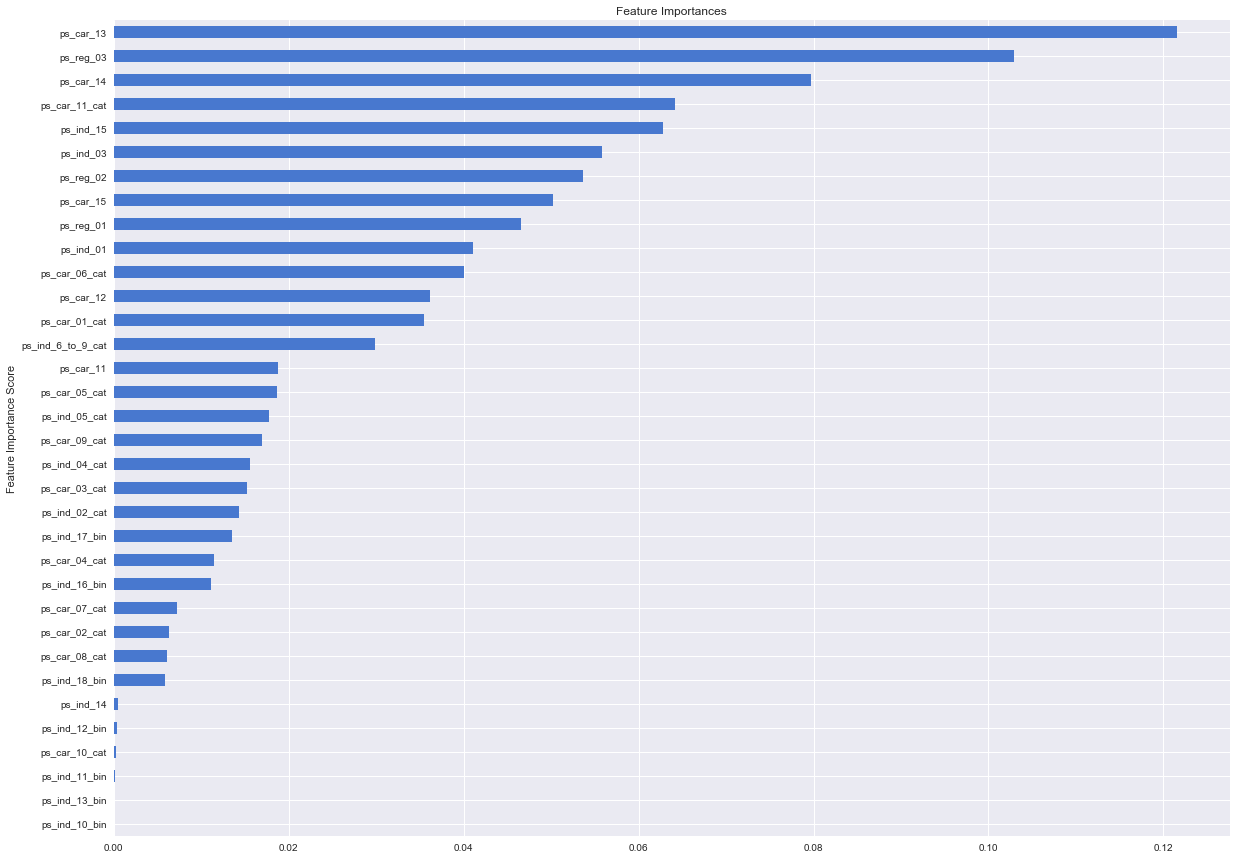

In [697]:
# Random Forests 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, class_weight='balanced', min_samples_leaf=25, min_samples_split=25)
modelfit(rf, X, y)

In [698]:
print('Start predicting...')
y_pred_b =rf.predict_proba(X_b)[:,1]
y_pred_c =rf.predict_proba(X_c)[:,1]
df_B['rf_predict_probs']=y_pred_b
df_C['rf_predict_probs']=y_pred_c

Start predicting...


In [700]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
modelfit(nb, X, y, printFeatureImportance=False)


Model Report
Accuracy : 0.9636
CV AUC Score : Mean - 0.6092 | Std - 0.006397 | Min - 0.5985 | Max - 0.6166
CV Gini score : 0.2183


In [701]:
print('Start predicting...')
y_pred_b =nb.predict_proba(X_b)[:,1]
y_pred_c =nb.predict_proba(X_c)[:,1]
df_B['nb_predict_probs']=y_pred_b
df_C['nb_predict_probs']=y_pred_c

Start predicting...



Model Report
Accuracy : 0.6898
CV AUC Score : Mean - 0.6328 | Std - 0.005974 | Min - 0.6245 | Max - 0.6421
CV Gini score : 0.2655


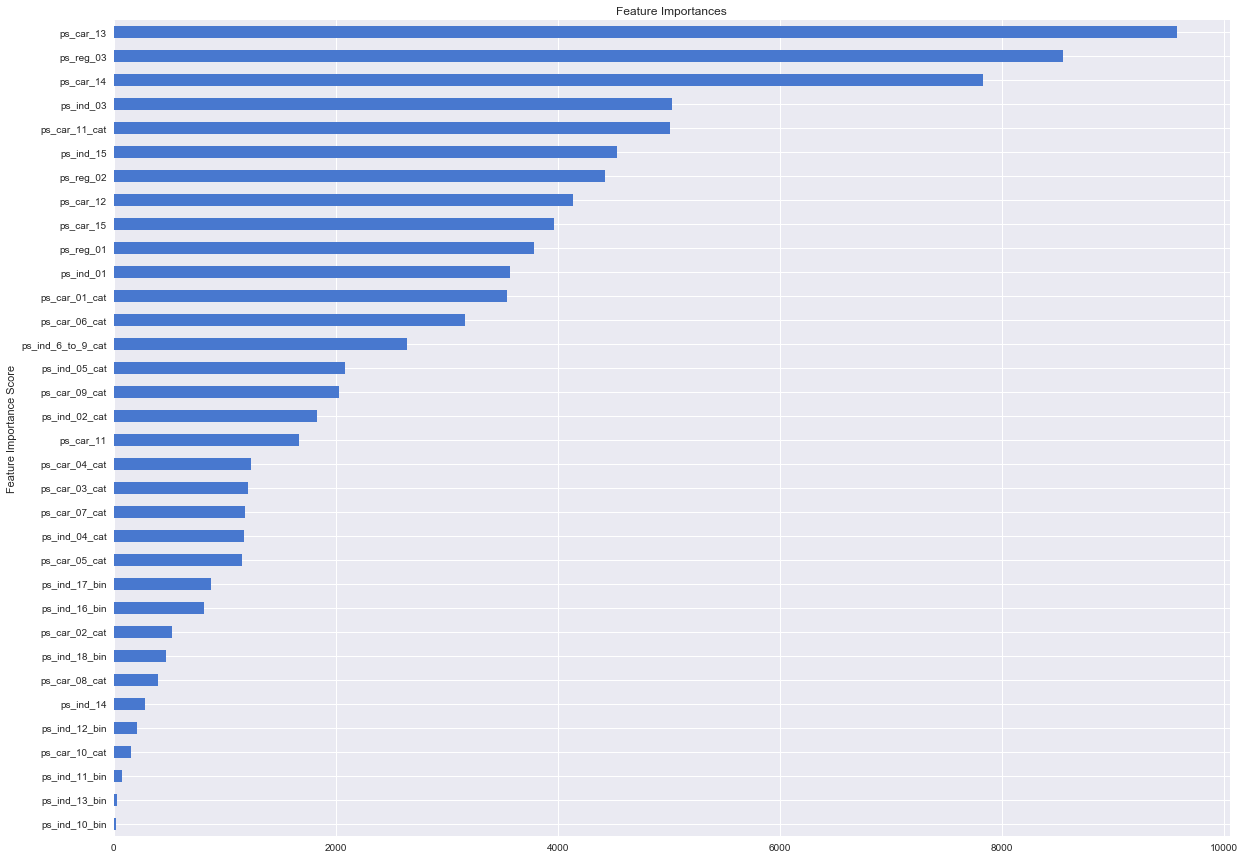

In [702]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.555,
        is_unbalance=True, learning_rate=0.005, max_bin=255, max_depth=8,
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=1301, nthread=-1, num_leaves=68, objective='binary',
        reg_alpha=0.61, reg_lambda=3, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)
modelfit(gbm, X, y)

In [ ]:
print('Start predicting...')
y_pred_b =gbm.predict_proba(X_b)[:,1]
y_pred_c =gbm.predict_proba(X_c)[:,1]
df_B['gbm_predict_probs']=y_pred_b
df_C['gbm_predict_probs']=y_pred_c

The base predictors (only) are used as features for a new meta predictor. 

In [726]:
use_cols4= [c for c in df_B.columns if c.endswith("probs")]
use_cols4

['lr_predict_probs',
 'rf_predict_probs',
 'nb_predict_probs',
 'gbm_predict_probs']

In [727]:
X = df_B[use_cols4]
y = df_B['target']
train_columns=df_B[use_cols4].columns
print(X.shape, y.shape)

(297606, 4) (297606,)



Model Report
Accuracy : 0.6157
CV AUC Score : Mean - 0.6339 | Std - 0.001731 | Min - 0.6323 | Max - 0.6363
CV Gini score : 0.2678


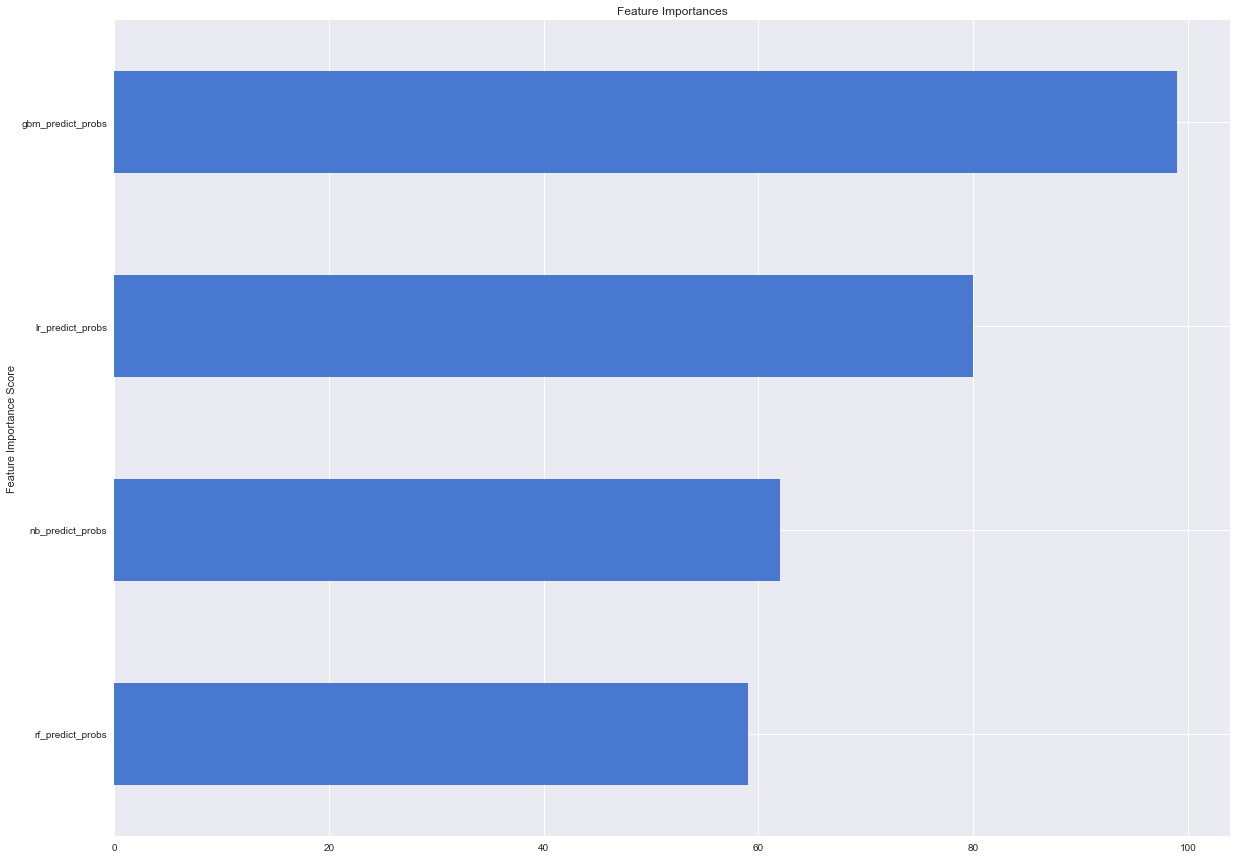

In [708]:
gbm_B1 = lgb.LGBMClassifier(is_unbalance=True, metric='auc', seed=32)
modelfit(gbm_B1, X, y)

Meta model tuning 

In [728]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
        'reg_lambda': int(params['reg_lambda']),
        'reg_alpha': '{:.2f}'.format(params['reg_alpha']),
        'max_depth' : int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
#     learning_rate=0.004,
#     n_estimators=1194,
#     num_leaves=64,
#     colsample_bytree=0.55,
#     reg_alpha=0.62, 
#     reg_lambda=3, 
        is_unbalance=True,
        **params
        )
    
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.uniform('num_leaves', 15, 30),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.85, 0.99),
    'reg_alpha': hp.uniform('reg_alpha', 0.3, 0.7),
    'reg_lambda': hp.quniform('reg_lambda', 3, 5, 1),
    'max_depth' :  hp.quniform('max_depth', 5, 7, 1),
    'n_estimators': hp.uniform('n_estimators', 300, 600),
    'learning_rate': hp.uniform('learning_rate', 0.004, 0.008)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=10)

Gini -0.2690 params {'num_leaves': 24, 'colsample_bytree': '0.8908', 'reg_lambda': 5, 'reg_alpha': '0.50', 'max_depth': 5, 'n_estimators': 524, 'learning_rate': '0.006'}
Gini -0.2689 params {'num_leaves': 23, 'colsample_bytree': '0.9185', 'reg_lambda': 4, 'reg_alpha': '0.62', 'max_depth': 7, 'n_estimators': 391, 'learning_rate': '0.008'}
Gini -0.2697 params {'num_leaves': 16, 'colsample_bytree': '0.9489', 'reg_lambda': 5, 'reg_alpha': '0.58', 'max_depth': 6, 'n_estimators': 554, 'learning_rate': '0.008'}
Gini -0.2702 params {'num_leaves': 20, 'colsample_bytree': '0.9820', 'reg_lambda': 4, 'reg_alpha': '0.40', 'max_depth': 7, 'n_estimators': 343, 'learning_rate': '0.007'}
Gini -0.2710 params {'num_leaves': 16, 'colsample_bytree': '0.8631', 'reg_lambda': 4, 'reg_alpha': '0.57', 'max_depth': 6, 'n_estimators': 375, 'learning_rate': '0.006'}
Gini -0.2679 params {'num_leaves': 28, 'colsample_bytree': '0.9502', 'reg_lambda': 3, 'reg_alpha': '0.66', 'max_depth': 7, 'n_estimators': 352, 'learn

In [730]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.9377207930972532, 'learning_rate': 0.004109976094824704, 'max_depth': 5.0, 'n_estimators': 338.58986156874624, 'num_leaves': 16.717318446263782, 'reg_alpha': 0.6992540825706401, 'reg_lambda': 4.0}


In [731]:
# Final model parameters.
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.004,
    n_estimators=339,
    num_leaves=17,
    colsample_bytree=0.94,
    reg_alpha=0.7, 
    reg_lambda=4, 
    max_depth=5,
    is_unbalance=True
    )

scores = cross_val_score(lgb_model, X, y, cv=StratifiedKFold(), scoring=gini_scorer)
print("Gini coefficient: %0.4f (+/- %0.4f) " % (scores.mean(), scores.std()))


Gini coefficient: -0.2713 (+/- 0.0023) 


Next, the predictions (ex. the lgb ones) are used as added features (rather than the only features) 

In [714]:
df_train.columns

Index(['id', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',
       'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11',
       'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15',
       'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'target', 'ps_ind_6_to_9_cat'],
      dtype='object')

In [732]:
use_cols5=['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',
       'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11',
       'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15',
       'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_ind_6_to_9_cat', 'lr_predict_probs', 'rf_predict_probs', 'nb_predict_probs']

In [733]:
X = df_B[use_cols5]
y = df_B['target']
train_columns=df_B[use_cols5].columns
print(X.shape, y.shape)

(297606, 37) (297606,)



Model Report
Accuracy : 0.6414
CV AUC Score : Mean - 0.6345 | Std - 0.003859 | Min - 0.6298 | Max - 0.6411
CV Gini score : 0.2689


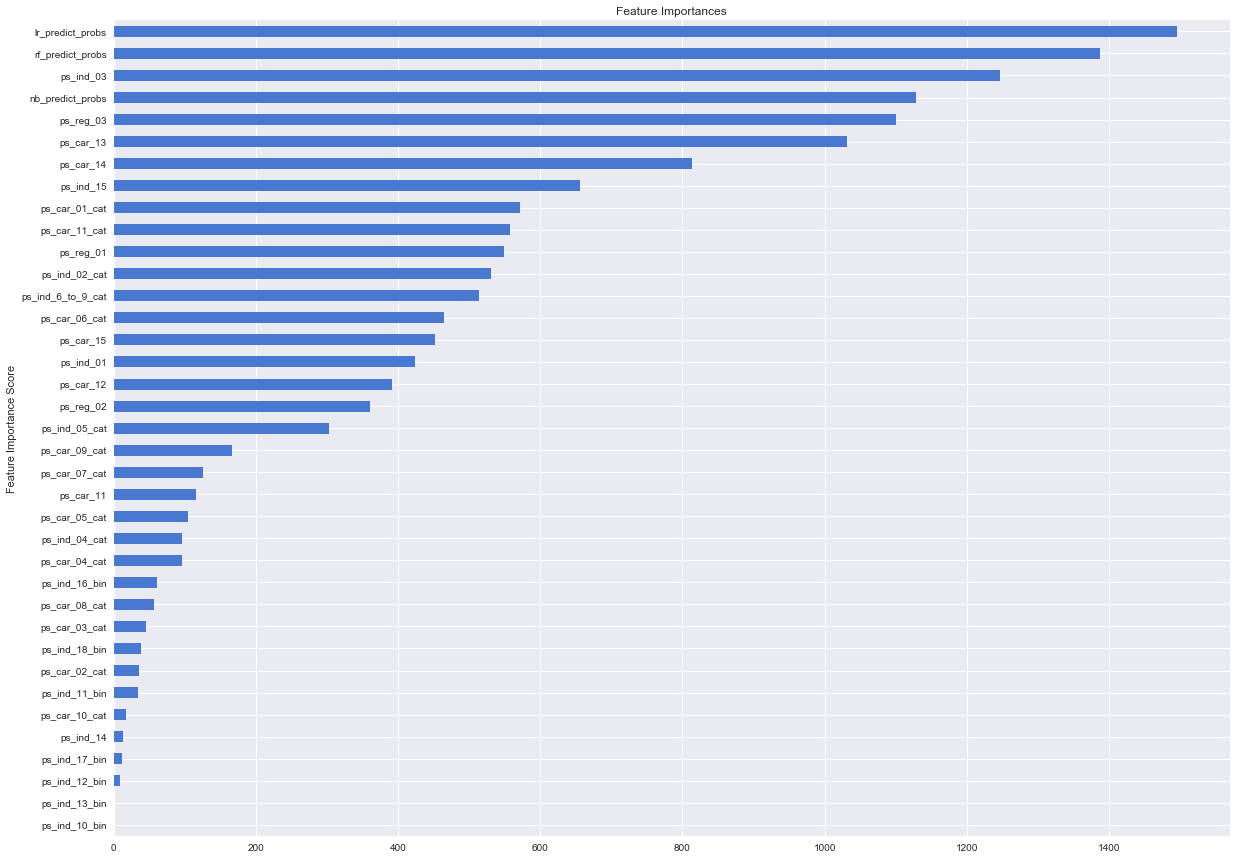

In [734]:
gbmB3 = lgb.LGBMClassifier(is_unbalance=True, learning_rate=0.01, metric='auc',  n_estimators=500)        
modelfit(gbmB3, X, y)

In [723]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
        'reg_lambda': int(params['reg_lambda']),
        'reg_alpha': '{:.2f}'.format(params['reg_alpha']),
        'max_depth' : int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
#        learning_rate=0.004,
#     n_estimators=1194,
#     num_leaves=64,
#     colsample_bytree=0.55,
#     reg_alpha=0.62, 
#     reg_lambda=3, 
        is_unbalance=True,
        **params
        )
    
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.uniform('num_leaves', 10, 80),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.45, 0.95),
    'reg_alpha': hp.uniform('reg_alpha', 0.5, 0.95),
    'reg_lambda': hp.quniform('reg_lambda', 1, 6, 1),
    'max_depth' :  hp.quniform('max_depth', 5, 9, 1),
    'n_estimators': hp.uniform('n_estimators', 200, 2000),
    'learning_rate': hp.uniform('learning_rate', 0.002, 0.05)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=20)

Gini -0.2647 params {'num_leaves': 67, 'colsample_bytree': '0.8616', 'reg_lambda': 5, 'reg_alpha': '0.66', 'max_depth': 6, 'n_estimators': 580, 'learning_rate': '0.007'}
Gini -0.2674 params {'num_leaves': 43, 'colsample_bytree': '0.8896', 'reg_lambda': 4, 'reg_alpha': '0.58', 'max_depth': 6, 'n_estimators': 270, 'learning_rate': '0.017'}
Gini -0.2654 params {'num_leaves': 14, 'colsample_bytree': '0.6593', 'reg_lambda': 3, 'reg_alpha': '0.63', 'max_depth': 6, 'n_estimators': 781, 'learning_rate': '0.028'}
Gini -0.2302 params {'num_leaves': 59, 'colsample_bytree': '0.7311', 'reg_lambda': 3, 'reg_alpha': '0.92', 'max_depth': 6, 'n_estimators': 1316, 'learning_rate': '0.020'}
Gini -0.2701 params {'num_leaves': 42, 'colsample_bytree': '0.4650', 'reg_lambda': 4, 'reg_alpha': '0.83', 'max_depth': 7, 'n_estimators': 492, 'learning_rate': '0.015'}
Gini -0.2511 params {'num_leaves': 63, 'colsample_bytree': '0.8340', 'reg_lambda': 5, 'reg_alpha': '0.76', 'max_depth': 8, 'n_estimators': 1524, 'lea

In [724]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.46503828975651124, 'learning_rate': 0.01531599170423594, 'max_depth': 7.0, 'n_estimators': 492.69063431787663, 'num_leaves': 42.200925608818416, 'reg_alpha': 0.8259698244444882, 'reg_lambda': 4.0}


In [725]:
# Final parameters

lgb_model = lgb.LGBMClassifier(
    learning_rate=0.015,
    n_estimators=493,
    num_leaves=42,
    colsample_bytree=0.47,
    reg_alpha=0.83, 
    reg_lambda=4, 
    max_depth=7,
    is_unbalance=True
    )

scores = cross_val_score(lgb_model, X, y, cv=StratifiedKFold(), scoring=gini_scorer)
print("Gini coefficient: %0.4f (+/- %0.4f) " % (scores.mean(), scores.std()))


Gini coefficient: -0.2700 (+/- 0.0027) 


In [738]:
lgb_model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.94, is_unbalance=True,
        learning_rate=0.004, max_bin=255, max_depth=5,
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=339, nthread=-1, num_leaves=17, objective='binary',
        reg_alpha=0.7, reg_lambda=4, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [739]:
# Prediction of the test dataset using the above tuned model and submission to Kaggle 
X_sub = df_C[use_cols5]
print(X_sub.shape)

(892816, 37)


In [740]:
print('Start predicting...')
y_pred_sub =lgb_model.predict_proba(X_sub)[:,1]

Start predicting...


In [741]:
y_pred_sub

array([ 0.39627914,  0.44444948,  0.47679095, ...,  0.49565564,
        0.47475682,  0.48832488])

In [742]:
len(y_pred_sub)

892816

In [743]:
submission= df_test

In [744]:
submission['target']=y_pred_sub

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [745]:
submission=submission[['id', 'target']]

In [746]:
submission.head()

,id,target
595212,0,0.396279
595213,1,0.444449
595214,2,0.476791
595215,3,0.371301
595216,4,0.492990


In [747]:
submission.target.max()

0.69150461295276699

In [748]:
submission.target.min()

0.29847329771333464

In [749]:
submission.to_csv('lgb_v43.csv', index=False, float_format='%.4f')

Your submission scored 0.252 (from Kaggle)

Prediction averaging

In [773]:
df_S=df_C

In [774]:
df_S.columns


Index(['id', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',
       'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11',
       'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15',
       'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'target', 'ps_ind_6_to_9_cat', 'lr_predict_probs', 'rf_predict_probs',
       'nb_predict_probs', 'gbm_predict_probs'],
      dtype='object')

In [767]:
df_S['target']=df_S[['lr_predict_probs', 'rf_predict_probs', 'nb_predict_probs', 'gbm_predict_probs']].mean(axis=1)

In [768]:
df_S=df_S[['id', 'target']]

In [769]:
df_S.head()

,id,target
595212,0,0.230630
595213,1,0.259855
595214,2,0.311971
595215,3,0.173049
595216,4,0.320449


In [755]:
df_S.to_csv('avg_scores_v1.csv', index=False, float_format='%.4f')

Your submission scored 0.245 (from Kaggle)

Prediction averaging... weighted toward LightGBM (and reverting to best stand-alone LightGBM scores)

In [782]:
df_F=pd.read_csv('lgb_v42.csv')

In [783]:
df_F.head(2)

,id,target
0,0,0.4088
1,1,0.4327


In [784]:
df_F.rename(columns={'target' : 'lgbm_pred_probs'}, inplace=True)

In [785]:
df_F.head(2)

,id,lgbm_pred_probs
0,0,0.4088
1,1,0.4327


In [786]:
df_S=df_S[['id', 'lr_predict_probs', 'rf_predict_probs', 'nb_predict_probs']]
df_S.head(2)

,id,lr_predict_probs,rf_predict_probs,nb_predict_probs
595212,0,0.401191,0.139644,0.019901
595213,1,0.463389,0.151429,0.020409


In [787]:
df_F=df_F.merge(df_S, on='id', how='left')
df_F.head()

,id,lgbm_pred_probs,lr_predict_probs,rf_predict_probs,nb_predict_probs
0,0,0.4088,0.401191,0.139644,0.019901
1,1,0.4327,0.463389,0.151429,0.020409
2,2,0.4111,0.437834,0.356805,0.024370
3,3,0.2690,0.344926,0.069516,0.012987
4,4,0.4926,0.474542,0.295929,0.020298


In [808]:
# df_F['target']=((df_F.lgbm_pred_probs*56) + df_F.lr_predict_probs + df_F.rf_predict_probs + df_F.nb_predict_probs) / 59

In [828]:
df_F['target']=df_F.lgbm_pred_probs.mul(.8)

In [829]:
df_F.describe()

,id,lgbm_pred_probs,lr_predict_probs,rf_predict_probs,nb_predict_probs,target
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,0.460176,0.478973,0.287324,0.039503,0.368141
std,4.296830e+05,0.112588,0.100003,0.116364,0.033190,0.090071
min,0.000000e+00,0.130800,0.189154,0.000000,0.005924,0.104640
25%,3.720218e+05,0.380000,0.407384,0.202620,0.020409,0.304000
50%,7.443070e+05,0.456700,0.467551,0.277486,0.029204,0.365360
75%,1.116308e+06,0.535300,0.539265,0.361909,0.045772,0.428240
max,1.488026e+06,0.936600,0.951971,0.820652,0.807022,0.749280


In [830]:
df_FF=df_F[['id', 'target']]
target=np.where(df_FF.target>1.00, 1.0, df_FF.target)
df_FF['target']=target
df_FF.describe()

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,target
count,8.928160e+05,892816.000000
mean,7.441535e+05,0.368141
std,4.296830e+05,0.090071
min,0.000000e+00,0.104640
25%,3.720218e+05,0.304000
50%,7.443070e+05,0.365360
75%,1.116308e+06,0.428240
max,1.488026e+06,0.749280


In [831]:
df_FF.to_csv('multiply_scores_v4.csv', index=False, float_format='%.4f')

Your submission scored 0.274 (weighting of 3X - LightGBM is 50% of total) 

Your submission scored 0.277 (weighting of 5X) 

Your submission scored 0.278 (weighting of 9X) 

Your submission scored 0.279 (weighting of 12X - LightGBM is 80% of total)

Your submission scored 0.279 (weighting of 27X - LightGBM is 90% of total)

Your submission scored 0.279 (weighting of 56X - LightGBM is 95% of total)

Your submission scored 0.279 (LightGBM X 1.03)

Your submission scored 0.279 (LightGBM X .80)



** Feature selection **  

In [90]:
df_train=df_train_test.loc[df_train_test['target']!= -1]
df_test=df_train_test.loc[df_train_test['target'] == -1]

In [91]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# load X and y - Can't have index values in array
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
X = df_train.drop(['id', 'target'], axis=1).values
y = df_train.target.values

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=50)

# find all relevant features 
feat_selector.fit(X, y)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	60
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 50
Confirmed: 	28
Tentative: 	4
Rejected: 	28


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 50
Confirmed: 	28
Tentative: 	3
Rejected: 	29


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 50
Confirmed: 	28
Tentative: 	3
Rejected: 	29


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 50
Confirmed: 	28
Tentative: 	3
Rejected: 	29


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 50
Confirmed: 	28
Tentative: 	3
Rejected: 	29


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 50
Confirmed: 	28
Tentative: 	3
Rejected: 	29


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 50
Confirmed: 	28
Tentative: 	2
Rejected: 	30


BorutaPy finished running.

Iteration: 	50 / 50
Confirmed: 	28
Tentative: 	1
Rejected: 	30


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=154, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x000001DC811D1DC8>,
            verbose=0, warm_start=False),
     max_iter=50, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x000001DC811D1DC8>,
     two_step=True, verbose=2)

In [92]:
# check selected features -
feat_selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True], dtype=bool)

In [93]:
# check ranking of features
feat_selector.ranking_

array([13, 10, 11, 17, 17, 19, 16, 14, 14,  8,  9, 20, 12,  6, 27, 28, 25,
       25, 28, 24,  1,  1,  1,  1, 22,  1,  1,  1,  2, 30,  3,  1,  1,  1,
        1,  1,  1,  4,  1,  4,  1,  1,  1,  1,  1, 33, 31, 21, 32, 22,  1,
        1,  1,  6,  1,  1,  1,  1,  1,  1])

In [94]:
col_names=df_train.drop(['id','target'], axis=1).columns
z= list(zip(col_names,feat_selector.ranking_))
print(z)

[('ps_calc_01', 13), ('ps_calc_02', 10), ('ps_calc_03', 11), ('ps_calc_04', 17), ('ps_calc_05', 17), ('ps_calc_06', 19), ('ps_calc_07', 16), ('ps_calc_08', 14), ('ps_calc_09', 14), ('ps_calc_10', 8), ('ps_calc_11', 9), ('ps_calc_12', 20), ('ps_calc_13', 12), ('ps_calc_14', 6), ('ps_calc_15_bin', 27), ('ps_calc_16_bin', 28), ('ps_calc_17_bin', 25), ('ps_calc_18_bin', 25), ('ps_calc_19_bin', 28), ('ps_calc_20_bin', 24), ('ps_car_01_cat', 1), ('ps_car_02_cat', 1), ('ps_car_03_cat', 1), ('ps_car_04_cat', 1), ('ps_car_05_cat', 22), ('ps_car_06_cat', 1), ('ps_car_07_cat', 1), ('ps_car_08_cat', 1), ('ps_car_09_cat', 2), ('ps_car_10_cat', 30), ('ps_car_11', 3), ('ps_car_11_cat', 1), ('ps_car_12', 1), ('ps_car_13', 1), ('ps_car_14', 1), ('ps_car_15', 1), ('ps_ind_01', 1), ('ps_ind_02_cat', 4), ('ps_ind_03', 1), ('ps_ind_04_cat', 4), ('ps_ind_05_cat', 1), ('ps_ind_06_bin', 1), ('ps_ind_07_bin', 1), ('ps_ind_08_bin', 1), ('ps_ind_09_bin', 1), ('ps_ind_10_bin', 33), ('ps_ind_11_bin', 31), ('ps_ind

In [108]:
z2=pd.DataFrame.from_records(z, columns=['feature', 'score'], index='feature').sort_values(by='score', ascending=True)
z2.to_pickle('feature_rankings_v2.pickle')
z2.head()

,score
feature,
ps_cluster100_cat,1
ps_car_01_cat,1
ps_car_02_cat,1
ps_car_03_cat,1
ps_car_04_cat,1


In [109]:
z2.head(29)

,score
feature,
ps_cluster100_cat,1
ps_car_01_cat,1
ps_car_02_cat,1
ps_car_03_cat,1
ps_car_04_cat,1
ps_car_06_cat,1
ps_car_07_cat,1
ps_ind_06_bin,1
ps_car_08_cat,1


In [110]:
boruta_feats=z2.loc[z2['score'] < 2]
boruta_feats.shape

(28, 1)

In [111]:
use_cols_boruta=list(boruta_feats.index)

In [112]:
print(use_cols_boruta)

['ps_cluster100_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_ind_06_bin', 'ps_car_08_cat', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_cluster50_cat', 'ps_ind_07_bin', 'ps_ind_05_cat', 'ps_ind_09_bin', 'ps_cluster10_cat', 'ps_reg_03', 'ps_reg_02', 'ps_reg_01', 'ps_ind_08_bin', 'ps_ind_17_bin', 'ps_ind_03', 'ps_ind_16_bin', 'ps_ind_15']


** Binning **

In [834]:
# Revert to "best" dataset
df_train_test=pd.read_csv('train_test_processed_vR1')

In [835]:
#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

In [836]:
cut_points_reg_03=[0.6473503238, 0.7875991751, 1.1223580002]
cut_points_car_12=[0.3161486893, 0.36048577665, 0.4471576868, 0.5174895957]
cut_points_car_13=[0.6335435891, 0.74983400365, 0.83207273795, 0.94365426285, 1.0896186496, 1.34690297485]
cut_points_car_14=[0.30724578685, 0.34720310315, 0.3818376394, 0.3825571797, 0.41623299945, 0.43566035775]

In [838]:
df_train_test["ps_reg_03_binned"] = binning(df_train_test["ps_reg_03"], cut_points_reg_03)
print (pd.value_counts(df_train_test["ps_reg_03_binned"], sort=False))

0    601335
1    255197
2    350926
3    280570
Name: ps_reg_03_binned, dtype: int64


In [844]:
df_train_test["ps_car_12_binned"] = binning(df_train_test["ps_car_12"], cut_points_car_12)
print (pd.value_counts(df_train_test["ps_car_12_binned"], sort=False))

0     80672
1    427731
2    780521
3    158377
4     40727
Name: ps_car_12_binned, dtype: int64


In [845]:
df_train_test["ps_car_13_binned"] = binning(df_train_test["ps_car_13"], cut_points_car_13)
print (pd.value_counts(df_train_test["ps_car_13_binned"], sort=False))

0    257947
1    426974
2    255127
3    243267
4    156993
5    101611
6     46109
Name: ps_car_13_binned, dtype: int64


In [846]:
df_train_test["ps_car_14_binned"] = binning(df_train_test["ps_car_14"], cut_points_car_14)
print (pd.value_counts(df_train_test["ps_car_14_binned"], sort=False))

0    211859
1    214566
2    492380
3     16620
4    357740
5    111987
6     82876
Name: ps_car_14_binned, dtype: int64


In [847]:
df_train_test.drop(['ps_reg_03', 'ps_car_12',  'ps_car_13', 'ps_car_14'], axis=1, inplace=True)

In [906]:
df_train_test.dtypes

id                      int64
ps_car_01_cat           int64
ps_car_02_cat           int64
ps_car_03_cat           int64
ps_car_04_cat           int64
ps_car_05_cat           int64
ps_car_06_cat           int64
ps_car_07_cat           int64
ps_car_08_cat           int64
ps_car_09_cat           int64
ps_car_10_cat           int64
ps_car_11               int64
ps_car_11_cat           int64
ps_car_15             float64
ps_ind_01               int64
ps_ind_02_cat           int64
ps_ind_03               int64
ps_ind_04_cat           int64
ps_ind_05_cat           int64
ps_ind_10_bin           int64
ps_ind_11_bin           int64
ps_ind_12_bin           int64
ps_ind_13_bin           int64
ps_ind_14               int64
ps_ind_15               int64
ps_ind_16_bin           int64
ps_ind_17_bin           int64
ps_ind_18_bin           int64
ps_reg_01             float64
ps_reg_02             float64
target                  int64
ps_ind_6_to_9_cat       int64
ps_reg_03_binned     category
ps_car_12_

In [907]:
binned_feat = [c for c in df_train_test.columns if c.endswith("binned")]
for col in binned_feat :
   df_train_test[col] = df_train_test[col].astype('int64')

In [908]:
df_train_test.dtypes

id                     int64
ps_car_01_cat          int64
ps_car_02_cat          int64
ps_car_03_cat          int64
ps_car_04_cat          int64
ps_car_05_cat          int64
ps_car_06_cat          int64
ps_car_07_cat          int64
ps_car_08_cat          int64
ps_car_09_cat          int64
ps_car_10_cat          int64
ps_car_11              int64
ps_car_11_cat          int64
ps_car_15            float64
ps_ind_01              int64
ps_ind_02_cat          int64
ps_ind_03              int64
ps_ind_04_cat          int64
ps_ind_05_cat          int64
ps_ind_10_bin          int64
ps_ind_11_bin          int64
ps_ind_12_bin          int64
ps_ind_13_bin          int64
ps_ind_14              int64
ps_ind_15              int64
ps_ind_16_bin          int64
ps_ind_17_bin          int64
ps_ind_18_bin          int64
ps_reg_01            float64
ps_reg_02            float64
target                 int64
ps_ind_6_to_9_cat      int64
ps_reg_03_binned       int64
ps_car_12_binned       int64
ps_car_13_binn

In [909]:
df_train_test.shape

(1488028, 36)

In [910]:
df_train=df_train_test.loc[df_train_test['target']!= -1]
df_test=df_train_test.loc[df_train_test['target'] == -1]

In [911]:
X = df_train.drop(['id', 'target'], axis=1)
y = df_train['target']
train_columns=df_train.drop(['id', 'target'], axis=1).columns
print(X.shape, y.shape)

(595212, 34) (595212,)


In [851]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
#         'reg_lambda': int(params['reg_lambda']),
#         'reg_alpha': '{:.2f}'.format(params['reg_alpha'])
#         'n_estimators': int(params['n_estimators']),
#         'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
         n_estimators=500,
         learning_rate=0.01,
#         num_leaves=24,
#         colsample_bytree=0.898,
#         reg_alpha=0.84, 
#         reg_lambda=1, 
        is_unbalance=True,
        **params
        )
    
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
#     'reg_alpha': hp.quniform('reg_alpha', 0.00, 1.00, 0.02),
#     'reg_lambda': hp.quniform('reg_lambda', 0, 6, 1)
#     'n_estimators': hp.uniform('n_estimators', 500, 2400),
#     'learning_rate': hp.uniform('learning_rate', 0.003, 0.01)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=15)

Gini -0.2821 params {'num_leaves': 34, 'colsample_bytree': '0.7309'}
Gini -0.2800 params {'num_leaves': 106, 'colsample_bytree': '0.7001'}
Gini -0.2798 params {'num_leaves': 26, 'colsample_bytree': '0.4347'}
Gini -0.2778 params {'num_leaves': 52, 'colsample_bytree': '0.3995'}
Gini -0.2756 params {'num_leaves': 118, 'colsample_bytree': '0.3995'}
Gini -0.2817 params {'num_leaves': 74, 'colsample_bytree': '0.6677'}
Gini -0.2832 params {'num_leaves': 76, 'colsample_bytree': '0.4750'}
Gini -0.2810 params {'num_leaves': 70, 'colsample_bytree': '0.7540'}
Gini -0.2822 params {'num_leaves': 82, 'colsample_bytree': '0.5687'}
Gini -0.2666 params {'num_leaves': 116, 'colsample_bytree': '0.3570'}
Gini -0.2814 params {'num_leaves': 32, 'colsample_bytree': '0.9257'}
Gini -0.2833 params {'num_leaves': 78, 'colsample_bytree': '0.5305'}
Gini -0.2823 params {'num_leaves': 112, 'colsample_bytree': '0.4730'}
Gini -0.2812 params {'num_leaves': 32, 'colsample_bytree': '0.9013'}
Gini -0.2822 params {'num_leav

In [852]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.5305351242785287, 'num_leaves': 78.0}


In [853]:
def objective(params):
    params = {
#         'num_leaves': int(params['num_leaves']),
#         'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
        'reg_lambda': int(params['reg_lambda']),
        'reg_alpha': '{:.2f}'.format(params['reg_alpha'])
#         'n_estimators': int(params['n_estimators']),
#         'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
         n_estimators=500,
         learning_rate=0.01,
         num_leaves=78,
         colsample_bytree=0.53,
#         reg_alpha=0.84, 
#         reg_lambda=1, 
        is_unbalance=True,
        **params
        )
    
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
#     'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
    'reg_alpha': hp.quniform('reg_alpha', 0.00, 1.00, 0.02),
    'reg_lambda': hp.quniform('reg_lambda', 0, 6, 1)
#     'n_estimators': hp.uniform('n_estimators', 500, 2400),
#     'learning_rate': hp.uniform('learning_rate', 0.003, 0.01)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=15)

Gini -0.2834 params {'reg_lambda': 5, 'reg_alpha': '0.90'}
Gini -0.2828 params {'reg_lambda': 4, 'reg_alpha': '0.78'}
Gini -0.2827 params {'reg_lambda': 1, 'reg_alpha': '0.18'}
Gini -0.2829 params {'reg_lambda': 3, 'reg_alpha': '0.62'}
Gini -0.2834 params {'reg_lambda': 4, 'reg_alpha': '0.28'}
Gini -0.2830 params {'reg_lambda': 1, 'reg_alpha': '0.96'}
Gini -0.2829 params {'reg_lambda': 1, 'reg_alpha': '0.30'}
Gini -0.2834 params {'reg_lambda': 4, 'reg_alpha': '0.28'}
Gini -0.2830 params {'reg_lambda': 4, 'reg_alpha': '0.64'}
Gini -0.2836 params {'reg_lambda': 4, 'reg_alpha': '0.74'}
Gini -0.2834 params {'reg_lambda': 5, 'reg_alpha': '0.96'}
Gini -0.2832 params {'reg_lambda': 1, 'reg_alpha': '0.80'}
Gini -0.2830 params {'reg_lambda': 1, 'reg_alpha': '0.76'}
Gini -0.2831 params {'reg_lambda': 3, 'reg_alpha': '0.28'}
Gini -0.2830 params {'reg_lambda': 4, 'reg_alpha': '0.18'}


In [854]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'reg_alpha': 0.74, 'reg_lambda': 4.0}


In [855]:
def objective(params):
    params = {
#         'num_leaves': int(params['num_leaves']),
# #       'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
#         'reg_lambda': int(params['reg_lambda']),
#         'reg_alpha': '{:.2f}'.format(params['reg_alpha'])
        'n_estimators': int(params['n_estimators']),
        'learning_rate': '{:.3f}'.format(params['learning_rate'])     
             }
    
    clf = lgb.LGBMClassifier(
#          n_estimators=500,
#          learning_rate=0.01,
         num_leaves=78,
         colsample_bytree=0.53,
         reg_alpha=0.74, 
         reg_lambda=4, 
         is_unbalance=True,
         **params
        )
     
    score = cross_val_score(clf, X, y, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.4f} params {}".format(score, params))
    return score

space = {
#     'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)
#     'reg_alpha': hp.quniform('reg_alpha', 0.00, 1.00, 0.02),
#     'reg_lambda': hp.quniform('reg_lambda', 0, 6, 1)
    'n_estimators': hp.uniform('n_estimators', 400, 2400),
    'learning_rate': hp.uniform('learning_rate', 0.003, 0.03)    
        }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, 
            max_evals=15)

Gini -0.2619 params {'n_estimators': 1248, 'learning_rate': '0.016'}
Gini -0.2361 params {'n_estimators': 1537, 'learning_rate': '0.023'}
Gini -0.2486 params {'n_estimators': 2016, 'learning_rate': '0.014'}
Gini -0.2675 params {'n_estimators': 1917, 'learning_rate': '0.009'}
Gini -0.2830 params {'n_estimators': 810, 'learning_rate': '0.009'}
Gini -0.2772 params {'n_estimators': 1084, 'learning_rate': '0.011'}
Gini -0.2641 params {'n_estimators': 1247, 'learning_rate': '0.015'}
Gini -0.2580 params {'n_estimators': 988, 'learning_rate': '0.022'}
Gini -0.2590 params {'n_estimators': 1365, 'learning_rate': '0.016'}
Gini -0.2757 params {'n_estimators': 989, 'learning_rate': '0.013'}
Gini -0.2789 params {'n_estimators': 2227, 'learning_rate': '0.005'}
Gini -0.2324 params {'n_estimators': 2347, 'learning_rate': '0.017'}
Gini -0.2309 params {'n_estimators': 1432, 'learning_rate': '0.027'}
Gini -0.2611 params {'n_estimators': 1899, 'learning_rate': '0.011'}
Gini -0.2682 params {'n_estimators': 

In [856]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'learning_rate': 0.008903970688305549, 'n_estimators': 810.3662540181856}


In [914]:
lgb_model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.53, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=-1, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=500, nthread=-1, num_leaves=78, objective='binary',
        reg_alpha=0.74, reg_lambda=4, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [915]:
X_sub = df_test.drop(['id', 'target'], axis=1)
print(X_sub.shape)

(892816, 34)


In [916]:
print('Start predicting...')
y_pred_sub =lgb_model.predict_proba(X_sub)[:,1]

Start predicting...


In [917]:
y_pred_sub

array([ 0.39401756,  0.40242284,  0.4185642 , ...,  0.47893205,
        0.36974113,  0.41525968])

In [918]:
submission= df_test

In [919]:
submission['target']=y_pred_sub

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [920]:
submission=submission[['id', 'target']]

In [921]:
submission.to_csv('binned_lgb_v4.csv', index=False, float_format='%.4f')

Your submission scored 0.278 (from Kaggle)  
Your submission scored 0.276  
Your submission scored 0.277  
Your submission scored 0.279  
Your submission scored 0.278  